In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gound State Preparation of Molecules Using VQE and GQE 

This notebook will provide an introduction to the ground state preparation problem on quantum computers and explore how approaches like the variational quantum eigensolver (VQE) are a good heuristic, but quickly run into problems. The rest of the lesson will introduce the Generative Quantum Eigensolver (GQE) through CUDA-Q Solver's easy to use API.  GQE is a technique that leverages AI to prepare ground states on the quantum computer with many benefits.

**Prerequisites:** This notebook assumes a basic knowledge of quantum algorithms and topics like states, gates, circuits, etc.  If you are unfamiliar with these terms, you may want to complete our "[Quick Start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" series. This notebook also assumes users have a basic understanding of some quantum chemical terminology such as molecular orbitals, molecular Hamiltonian, etc. 

**What you will do:**

* Understand the importance of ground state prepartation.
* Use VQE to prepare the ground state of a molecule.
* Study the shortcomings of VQE.
* Learn how the generative quantum eigensolver works.
* Use GQE in CUDA-Q Solvers to prepare molecular ground states.
* Explore different settings for GQE model training.

**CUDA-Q Syntax you will use:**
* cudaq.observe()
* solvers.create_molecule
* solvers.gqe()
* solvers.get_pauli_pool()

Run the cells below to load all the necessary packages for this notebook.  You may need to restart your kernel after doing so.

In [2]:
# If you are working in an environment that does not have cudaqx installed, 
# uncomment the code below to install cudaq-solvers and the required dependencies.  
# Then restart the kernel before executing the next cell.
#!sudo apt-get update && sudo apt-get install -y gfortran
#!pip install cudaq-solvers -q

!pip install cudaq-solvers -q
!pip install cudaq-solvers[gqe] -q
import cudaq, cudaq_solvers as solvers
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

/home/cudaq/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The Ground State Problem

A fundamental quantity in quantum chemistry is the expectation value determined from a Hamiltonian operator $H$ and a quantum state (wavefunction) $\ket{\Psi}$.  The expectation value is defined as the average energy of the state $\ket{\Psi}$ and is represented with the following expression.

$$E =  \bra{\Psi}H\ket{\Psi}$$ 

This energy can be computed for any arbitrary state, but is often most important when obtained from a particular state called the **ground state**. The ground state is defined as the state which produces the lowest expectation value. 

For chemists, the ground state energy of a molecule provides a wealth of knowledge about its reactivity and chemical properties as most molecules are in the ground state rather than excited states. For quantum computing more broadly, non-physics optimization problems can often be mapped to a Hamiltonian. The ground state of such a Hamiltonian, if obtained, can be sampled to produce high-quality solutions to the original optimization problem.  

<figure>
  <img src="Images/vqe_and_gqe/pes.png" alt="plot" width="600">
  <figcaption>Accurate ground state energies are necessary to compute the strength of a chemical bond and other important properties. </figcaption>
</figure>

Identifying and preparing the gound state is an incredible challenge and is necessary to obtain quantities like the ground state energy. Consider an arbitrary quantum state constructed from $N$ qubits which is defined by a $2^N$ state vector of complex entries called amplitudes.  These amplitudes can take any complex value as long as they remain normalized.  

$$
|\psi\rangle =
\begin{pmatrix}
\alpha_0 \\
\alpha_1 \\
\vdots \\
\alpha_{2^n-1}
\end{pmatrix}
\qquad
\text{with} \qquad
\sum_{k=0}^{2^n-1} |\alpha_k|^2 = 1
$$

The first issue arises from the exponential size of the quantum state.  Even if one knows all parameters of a given ground state exactly, it is impossible to store a complete state vector for systems of just over 50 qubits, even if we could pool the memory of every supercomputer in the world! 

Quantum computing subverts this issue using superposition and instead representing quantum states as circuits where a sub-exponential number of gates can be applied to $N$ qubits. See the example below. A 16 element state vector is constructed using only 8 gates applied to 4 qubits. 

<figure>
  <img src="Images/vqe_and_gqe/sv.png" alt="plot" width="600">
</figure>

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
        Calculate the number of elements in the state vector and the number of gates required to prepare the same uniform superposition state for a system with 10 qubits and a system with 20 qubits.
    </p>
</div>

The second issue pertains to actually preparing a ground state with a quantum circuit. There is an infinite number of possible gate combinations and, without any intuition, blindly preparing a ground state circuit might be just as challenging as the original problem.  Cases like chemistry make this a bit easier because the underlying physics provides some structure , but finding the exact ground state may still require a prohibitively large number of gate operations for practical purposes.

This is where approximate methods are important for preparing states that are "close enough" to the ground state.


## Variational Methods and their Problems

Thanks to the **variational theorem**, the search for a circuit that approximates the ground state can become a bit more systematic. The variational theorem states that for any normalized trial wavefunction $\ket{\Psi_{trial}}$ that

$$\bra{\Psi_{trial}}H\ket{\Psi_{trial}} \ge E_0, $$

where $E_0$ is the ground state energy. This means that any trial wavefunction will produce an energy that is an upper bound to the ground state energy. In other words, we can try any trial wavefunction and the lowest energy result is the best approximation of the ground state.  This at least provides a way to rank our trial wavefunctions.

This fact has inspired an entire class of quantum algorithms called **variational algorithms** which take advantage of the strengths of both quantum and classical processors working in tandem. The image below depicts the workflow of a general variational algorithm. 

<img src="Images/vqe_and_gqe/variational-diagram.png" alt="plot" width="900">

Th steps are as follows: 

1. A predetermined structure or **(ansatz)** of a circuit is chosen where some of the rotation gates are parameterized ($\Theta={\theta_0 \cdots \theta_n}$).
2. The parameters are then randomly initialized (i.e., $\Theta$ is set to $\Theta_0$).
3. An expectation value is computed on a quantum computer using the $\bra{\Psi(\Theta)}H\ket{\Psi(\Theta)}$.
4. The resulting energy is fed into a classical optimizer which updates the parameter values $\Theta$.
5. Steps 3 and 4 are repeated until convergence.



Despite the ingenuity behind variational algorithms, there are many problems that limit their effectiveness.  One of the most documented is the so-called barren plateau problem.  For even small cases, like the 14-qubit example taken from ["Quantum variational algorithms are swamped with traps"](https://www.nature.com/articles/s41467-022-35364-5) shown below, the loss function landscape is extremely challenging, and, at problem sizes of even moderate size, the landscape usually becomes too flat to optimize. 

 <img src="Images/vqe_and_gqe/surface.png" alt="plot" width="900">

We have also assumed evaluation of $\bra{\Psi_{trial}}H\ket{\Psi_{trial}}$ is efficient on a QPU in the sense that it is possible to obtain expectation values for states much larger than ever possible with exact classical methods.  However, the wallclock time to run these on a QPU may still be quite costly and produce a practical limitation for VQE.  The barren plateau problem makes this problem worse as larger molecule require many more steps to converge the energy, if it will converge at all.  Gradients can help, but are extremely costly to evaluate in their own right.

Consider the image below.  $H_2$ quickly converges as it has only three parameters, but even a small molecule like $N_2$ has 609 parameters and is far from converged after 300 iterations.  Considering the exact energy of these molecules can easily be computed exactly with matrix diagonalization and convergence issues are already becoming apparent means systems that require large number of qubits quickly become prohibitive to solve.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
        Use the CUDA-Q Solvers code below to run VQE for $H_2$, $LiH$, and $N_2$ with a standard unitary coupled cluster with singled and double excitations (UCCSD) ansatz.  Note how many parameters are required for each system and comment on the convergence behavior.   Note, that these are still very small molecules with small basis sets.  Try playing around with the function $\texttt{stateprep.get\_num\_uccsd\_parameters}$ with different qubit counts and number of electrons to see how parameter numbers can quickly get out of hand.
    </p>
</div>



UCCSD-VQE energy =   -1.1372838340724294
Number of Variational Parameters = 3


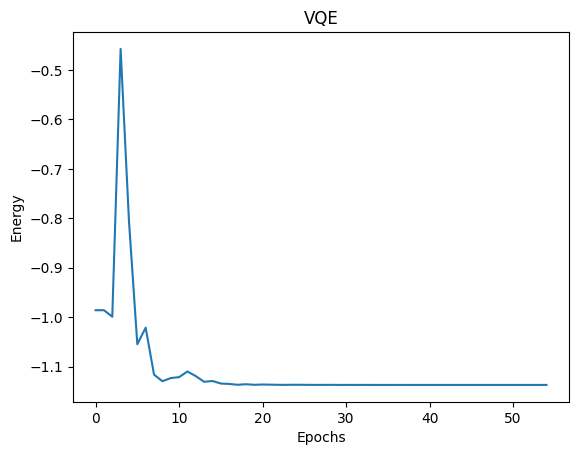

{ 0011:8 1100:992 }



In [3]:

# Create the molecular hamiltonian
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
#geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.59))]
#geometry = [('N', (0., 0., 0.)), ('N', (0., 0., 1.10))]
molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, CASCI = True)


# Get the number of qubits and electrons
numQubits = molecule.n_orbitals * 2
numElectrons = molecule.n_electrons

spin = 0
initialX = [-.2] * solvers.stateprep.get_num_uccsd_parameters(
    numElectrons, numQubits)


# Define the UCCSD ansatz
@cudaq.kernel
def ansatz(thetas: list[float]):
    q = cudaq.qvector(numQubits)
    for i in range(numElectrons):
        x(q[i])
    solvers.stateprep.uccsd(q, thetas, numElectrons, spin)


def cost(theta):

    exp_val = cudaq.observe(ansatz, molecule.hamiltonian, theta).expectation()

    return exp_val

exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


cudaq.set_target("nvidia", option = 'fp64')
result = minimize(cost,
                  initialX,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 300})

print('UCCSD-VQE energy =  ', result.fun)
print('Number of Variational Parameters =', len(initialX))

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()


print(cudaq.sample(ansatz, result.x))

Another issue is ansatz selection. The quality of the result is limited by how expressive the selected ansatz is. In the case of $H_2$, the ground state can be obtained exactly, because the UCCSD ansatz provides sufficient entanglement structure to match the exact full configuration interaction (FCI) result. 

This is not necessarily true if we select some other ansatz.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
        Use the code below to specify a custom ansatz in the kernel below in the following manner. Apply $H$ gates to the two occupied qubits.  Add CNOT gates between each adjacent qubit pair and then apply a parameterized $R_X$, $R_Y$, and $R_Z$ to each qubit.  This should result in a VQE with 12 parameters, 6 times more than UCCSD.  Comment on the convergence of the problem.  How does the final energy compare to the FCI energy? Why might this be the result? Hint: Try running $\texttt{cudaq.sample()}$ for the converged UCCSD result and for your ansatz.
    </p>
</div>

{'nuclear_energy': 0.7151043390810812, 'hf_energy': -1.1167593073964255, 'fci_energy': -1.1372838344885023}
     ╭───╮╭───╮               ╭───╮╭──────────╮╭──────────╮╭──────────╮
q0 : ┤ x ├┤ h ├──●────────────┤ x ├┤ ry(-0.3) ├┤ rx(-0.3) ├┤ rz(-0.3) ├
     ├───┤├───┤╭─┴─╮          ╰─┬─╯├──────────┤├──────────┤├──────────┤
q1 : ┤ x ├┤ h ├┤ x ├──●─────────┼──┤ ry(-0.3) ├┤ rx(-0.3) ├┤ rz(-0.3) ├
     ╰───╯╰───╯╰───╯╭─┴─╮       │  ├──────────┤├──────────┤├──────────┤
q2 : ───────────────┤ x ├──●────┼──┤ ry(-0.3) ├┤ rx(-0.3) ├┤ rz(-0.3) ├
                    ╰───╯╭─┴─╮  │  ├──────────┤├──────────┤├──────────┤
q3 : ────────────────────┤ x ├──●──┤ ry(-0.3) ├┤ rx(-0.3) ├┤ rz(-0.3) ├
                         ╰───╯     ╰──────────╯╰──────────╯╰──────────╯

Custom Ansatz Energy =   -0.4881944392582748
Number of Variational Parameters = 12
Variational Parameters = [ 1.57100134e+00  3.14266581e+00  3.14132868e+00  5.47478617e-04
 -3.42442827e-04  3.14409658e+00  1.66060110e-04 -3.87173053e-04
  1.9

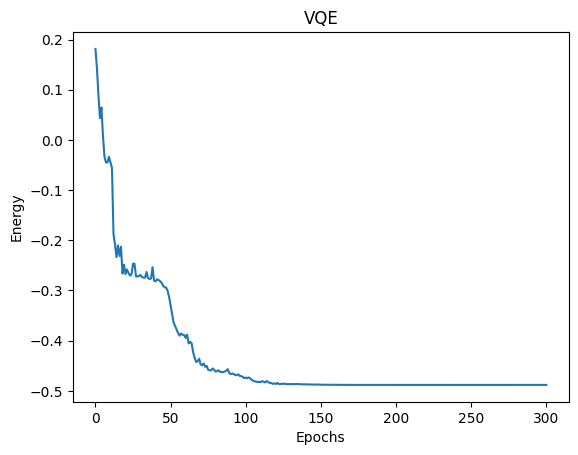

{ 1010:505 1101:495 }



In [4]:
cudaq.set_target("nvidia", option = 'fp64')
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]

molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, casci = True)

print(molecule.energies)

# Get the number of qubits and electrons
numQubits = molecule.n_orbitals * 2
numElectrons = molecule.n_electrons

spin = 0
initialX = [-.3] * 12

@cudaq.kernel
def custom_ansatz(thetas: list[float]):
    q = cudaq.qvector(numQubits)

    x(q[0]) #prepares Hartree Fock State
    x(q[1])

    h(q[0]) #prepares Hartree Fock State
    h(q[1])

    #TODO START


print(cudaq.draw(custom_ansatz, initialX))
        

def cost(theta):

    exp_val = cudaq.observe(custom_ansatz, molecule.hamiltonian, theta).expectation()

    return exp_val

exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))

cudaq.set_target('nvidia')
result = minimize(cost,
                  initialX,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 300})

print('Custom Ansatz Energy =  ', result.fun)
print('Number of Variational Parameters =', len(initialX))
print('Variational Parameters =', result.x)

print(cudaq.draw(custom_ansatz, result.x))

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

#TODO
print(cudaq.sample(custom_ansatz, result.x)) #does not preserve particle number

Chemistry provides some good intuition for ansatz selection, but this starts to break down with larger, strongly correlated molecules.

## The Generative Quantum Eigensolver

In an attempt to address the issues posed by VQE for finding molecular ground states, researchers from NVIDIA, U. Toronto, and St Jude Children's Research Hospital developed a technique called the generative quantum eigensolver (GQE) which uses a generative pretrained transformer (GPT) model to sample circuits which approximate a molecule's ground state. 

This section will explain some of the technical details of GQE, but first consider how this compares to VQE at a high level. The diagram below shows the two workflows. 

 <img src="Images/vqe_and_gqe/gqe_vqe.png" alt="plot" width="900">
Notice that both are similar in the sense that a quantum circuit is prepared and sampled to produce an energy which informs how the model parameters are updated.  The key difference is that with GQE, the optimized parameters are the neural network parameters of the GPT model and not within the quantum circuits.  This provides a much better optimization landscape, avoiding the barren plateau issue. There are further benefits related to pretraining, but these will be discussed later.

Let's zoom in a bit on how the GPT model works and circuits are sampled.  First, the model needs a vocabulary.  The natural choice is a set of time evolution operators derived from a chemically inspired ansatz like UCCSD.  In the paper, the authors have a large set of operators of the form $e^{iP_jt_k}$ where $P_j$ is an operator from UCCSD and  $t_k$ is some a time step selected from a range of possible time steps. 

Just as ansatz selection for VQE was critical for convergence, a good vocabulary is key for GQE.  GQE just needs to be given an vocabulary that is flexible enough. It is also possible to select a vocabulary tuned to specific qubit modalities such as those with nearest neighbor connectivity.


The sampling process is shown in the figure below.  The GPT model takes the parameters, the vocabulary, an a partially constructed circuits (initially an empty circuit) as inputs.  The GPT model then outputs a logit vector related to the probability of sampling index $i$ corresponding to the $i$-th unitary in the vocabulary.  This index is then appended to the string and fed back into the GPT model until a sequence of $N$ (user specified) indices is created, i.e. the full circuit. 


 <img src="Images/vqe_and_gqe/gqe_sample.png" alt="plot" width="900">
This is the same process as a large language model (LLM) building a sentence.  If the input sentence is "The apple is colored..." A logit would be produced that would sample the token "red" with high probability.  The GQE model similarly learns which unitaries help construct a circuit close to the ground state. 


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
In the cell below, assume that the provided logit (w) was output from the GPT model.  Finish the function to compute the probability that each index $i=0$ to $i=9$ is sampled given an activation function of $e^{-\beta w_i}$ is used (like in the paper).  $\beta = \frac{1}{T}$ is called the inverse temperature as it is related to a Boltzmann distribution from statistical mechanics in this content.  Start with $\beta =1$.  What happens to the distribution when you change $\beta$?  Why might it be helpful to adjust beta during GQE sampling?  
    </p>
</div>



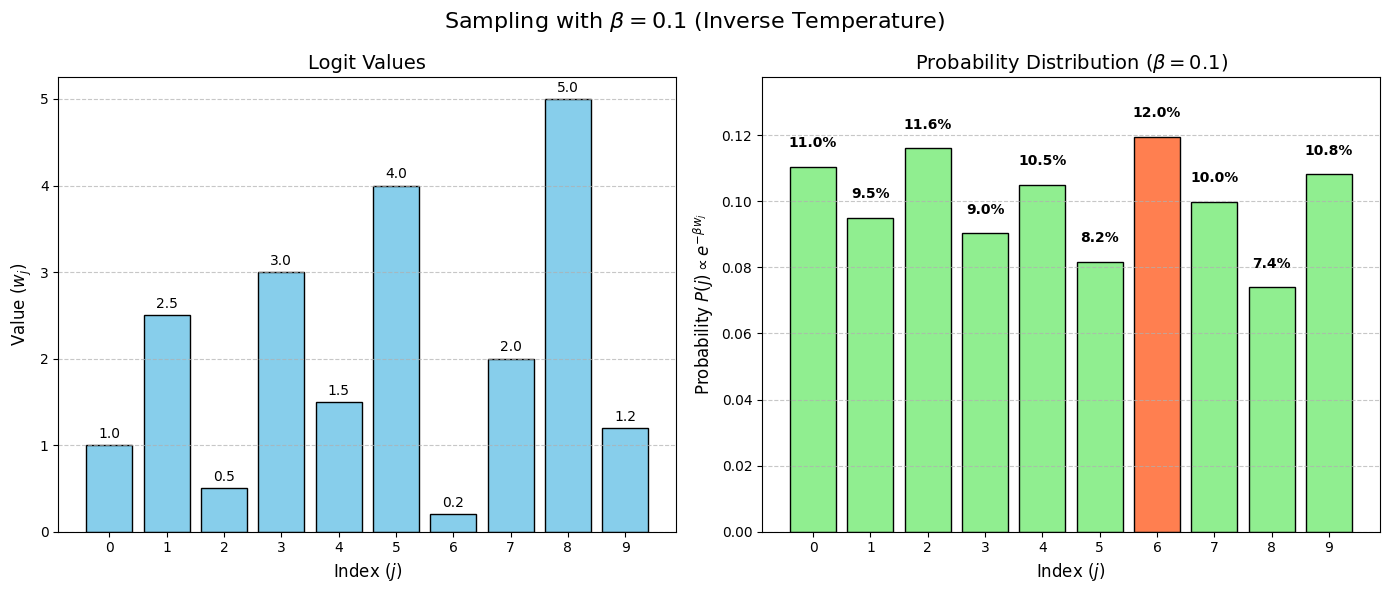

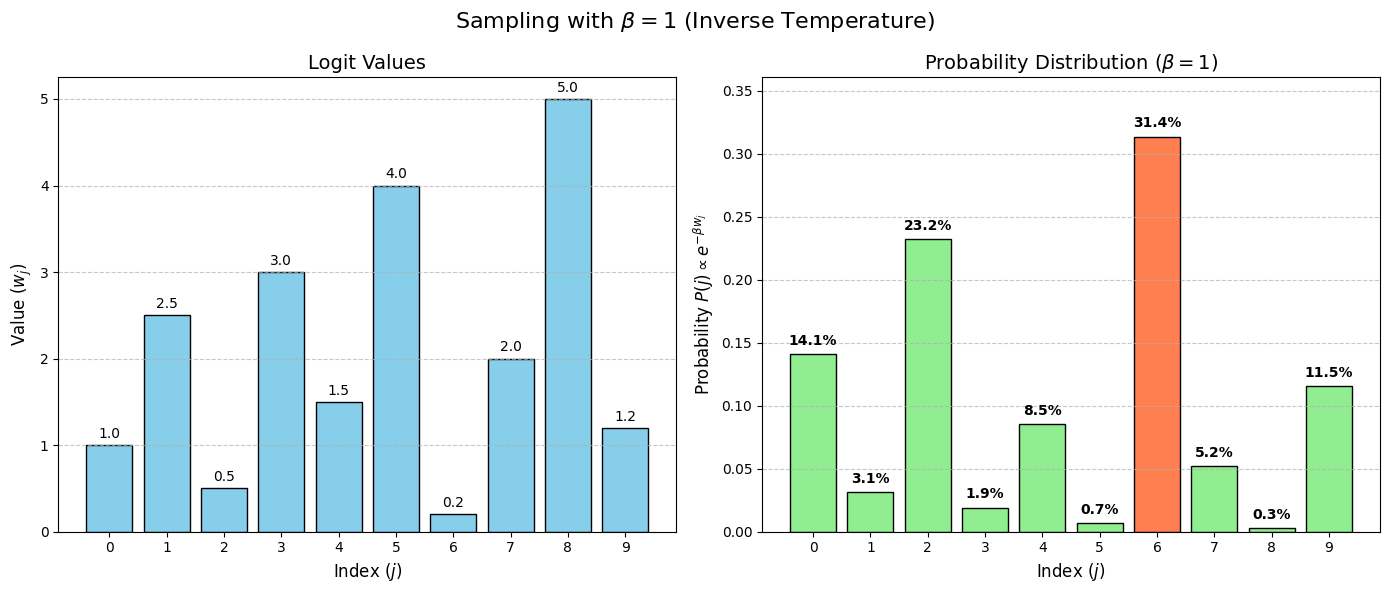

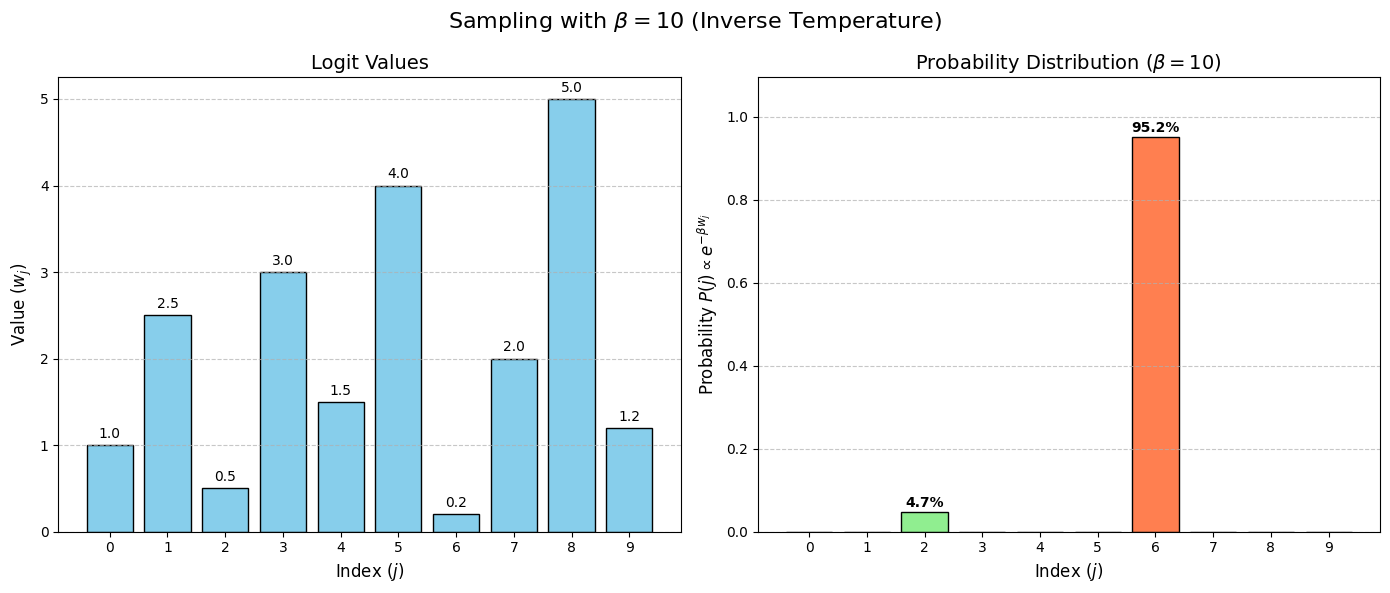

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boltzmann_distribution(w, beta):
    """
    Plots the energy vector w and the resulting probability distribution
    for a given inverse temperature beta.
    """

    #TODO - compute the probabilites

    probabilities = 
#--------------Setup Plotting-------------------------
    indices = np.arange(len(w))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    bars1 = ax1.bar(indices, w, color='skyblue', edgecolor='black')
    ax1.set_title(f'Logit Values', fontsize=14)
    ax1.set_xlabel('Index ($j$)', fontsize=12)
    ax1.set_ylabel('Value ($w_j$)', fontsize=12)
    ax1.set_xticks(indices)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                 f'{height:.1f}', ha='center', va='bottom')
        
    colors = ['coral' if p == max(probabilities) else 'lightgreen' for p in probabilities]
    bars2 = ax2.bar(indices, probabilities, color=colors, edgecolor='black')
    
    ax2.set_title(f'Probability Distribution ($\\beta={beta}$)', fontsize=14)
    ax2.set_xlabel('Index ($j$)', fontsize=12)
    ax2.set_ylabel('Probability $P(j) \\propto e^{-\\beta w_j}$', fontsize=12)
    ax2.set_xticks(indices)
    ax2.set_ylim(0, max(probabilities) * 1.15) # Add headroom for text
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0.001: # Only label if visible
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                     f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.suptitle(f'Sampling with $\\beta={beta}$ (Inverse Temperature)', fontsize=16)
    plt.tight_layout()
    plt.show()

w = [1.0, 2.5, 0.5, 3.0, 1.5, 4.0, 0.2, 2.0, 5.0, 1.2]


plot_boltzmann_distribution(w,0.1)
plot_boltzmann_distribution(w,1)
plot_boltzmann_distribution(w,10)

Now you have an understanding of how circuits are constructed with the GQE model, and we can revisit the training procedure.  For each training Epoch, GQE will sample a set of $C$ circuits. A quantum computer is then required to sample each circuit to compute an expectation value.  Each of these evaluations can be done asynchronously on many QPUs in parallel, a workflow that CUDA-Q enables. 

There are a number of ways to evaluate the cost function from this collection of energies including procedures called logit matching loss and group relative policy optimization-based loss, with the latter generally a better choice to avoid instances where the loss decreases but the energy plateaus. Curious readers can explore the details of these loss functions in the appendix of "The Generative Quantum Eigensolver (GQE) and its Application for Ground State Search".  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
This exercise will help you explore why GQE is more efficient and scalable compared to VQE. Consider the three plots below that demonstrate simulated comparison of GQE and VQE.  Comment on the accuracy of VQE vs GQE.  Now, complete the tables below to compare the quantum resources used between the two methods. Any user inputs are provided for you, and remember you can use functions from solvers to compute the number of UCCSD parameters.  Is there a benefit in the number of circuits run?  Are the circuits simpler?
         <img src="Images/vqe_and_gqe/vqe_vs_gqe.png" alt="plot" width="1300">
</div>

| Molecule | BeH$_2$ | N$_2$ | CO$_2$ |
| :--- | :---: | :---: | :---: |
| **Active Space (e, o)** | (4,6) | (6,6) | (9,10) |
| **VQE Parameters (UCCSD)** |  | |  |
| **VQE Epochs** |2000  | 3000| 10000 |
| **VQE Circuit Evals. per Epoch** | 184 |234 | 1120 |
 **Total VQE Circuit Evals.** |  | |  |
| **GQE Epochs** | 500 |3000 | 5000 |
| **GQE Evals. per Epochs** | 50 |50 | 50 |
| **Total GQE Circuit Evals.** |  | |  |
| **GQE Total Circuit Evals. (% of VQE)** |  | |  |


| Molecule | BeH$_2$ | N$_2$ | CO$_2$ |
| :--- | :---: | :---: | :---: |
| **Active Space (e, o)** | (4,6) | (6,6) | (9,10) |
| **VQE Operators (Parameters) per Circuit** |  |  |  |
| **GQE Operators per Circuit** | 60 | 100| 200 |
| **GQE Operators (% of VQE)** |  | |  |



In [6]:
print(solvers.stateprep.get_num_uccsd_parameters(4,12))
print(solvers.stateprep.get_num_uccsd_parameters(6,12))
print(solvers.stateprep.get_num_uccsd_parameters(10,18))

92
117
560


## Running GQE with CUDA-Q Solvers


GQE can be used in CUDA-Q Solvers but requires an additional install `pip install cudaq-solvers[gqe] -q`.

Running the GQE method in CUDA-Q Solvers is simple and can be broken down into a few simple steps. First a molecular Hamiltonian is constructed just like you would do for VQE. Next, an operator pool is constructed. The built-in function `get_gqe_pauli_pool` takes a list of potential parameters and combines them with the base UCCSD operators to form a collection of different operators and evolution time steps.  Note, you can customize this if you want, but we will just use the built-in function. 

Next, a cost function is defined which utilizes a CUDA-Q kernel to apply the selected operators.

Finally, configuration settings for the model are specified that determine its training behavior.  More on these later. 

The model then runs using the following API call: `solvers.gqe(cost, op_pool, config=cfg)` which produces the lowest energy circuit found by the routine and its corresponding operators.

An entire code example can be found [here](https://nvidia.github.io/cudaqx/examples_rst/solvers/gqe.html) with all of these steps. Explore the script if you want to develop your own workflow using GQE.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
To understand the GQE results, you will run a script called `run_gqe_h1.py` which is based off of the main workflow above, but with a few additional flags you can run to explore different settings in this notebook and easily plot the results.

Each example below considers $H_2$ with a 6-31G basis set and a (2,3) active space. This is a simple molecule to make model training fast but also see some interesting trends.

Important: you will change parameters and observe different model behavior.  We have set a random seed so results are reproducible. The trends we comment on will vary from system to system so the point is not to draw universal conclusions but see some of the challenges and considerations that arise with the GQE method.


💻 Just a heads-up: The rest of this notebook is designed to be run on an environment with a GPU. If you don't have access to a GPU, feel free to run the cells under script calls to load the precomputed results. Enjoy learning! ⭐
</div>



Full CI Energy (R-CASCI): -1.1382282118692268
Configuration: max_iters=50, ngates=20, num_samples=5, temperature=5.0
Seed set to 3047
total trainable params: 86.21M
epoch 0 loss tensor(1.8438, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 1.0050101280212402 tensor(-1.1069)
epoch 1 loss tensor(2.4296, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3632352352142334 tensor(-1.1206)
epoch 2 loss tensor(1.6121, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.4169433116912842 tensor(-1.0718)
epoch 3 loss tensor(1.0922, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.37125253677368164 tensor(-1.1028)
epoch 4 loss tensor(0.8473, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.361452579498291 tensor(-1.1077)
epoch 5 loss tensor(1.4707, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.35846948623657227 tensor(-1.1052)
epoch 6 loss tensor(2.1361, device='cuda:0', gra

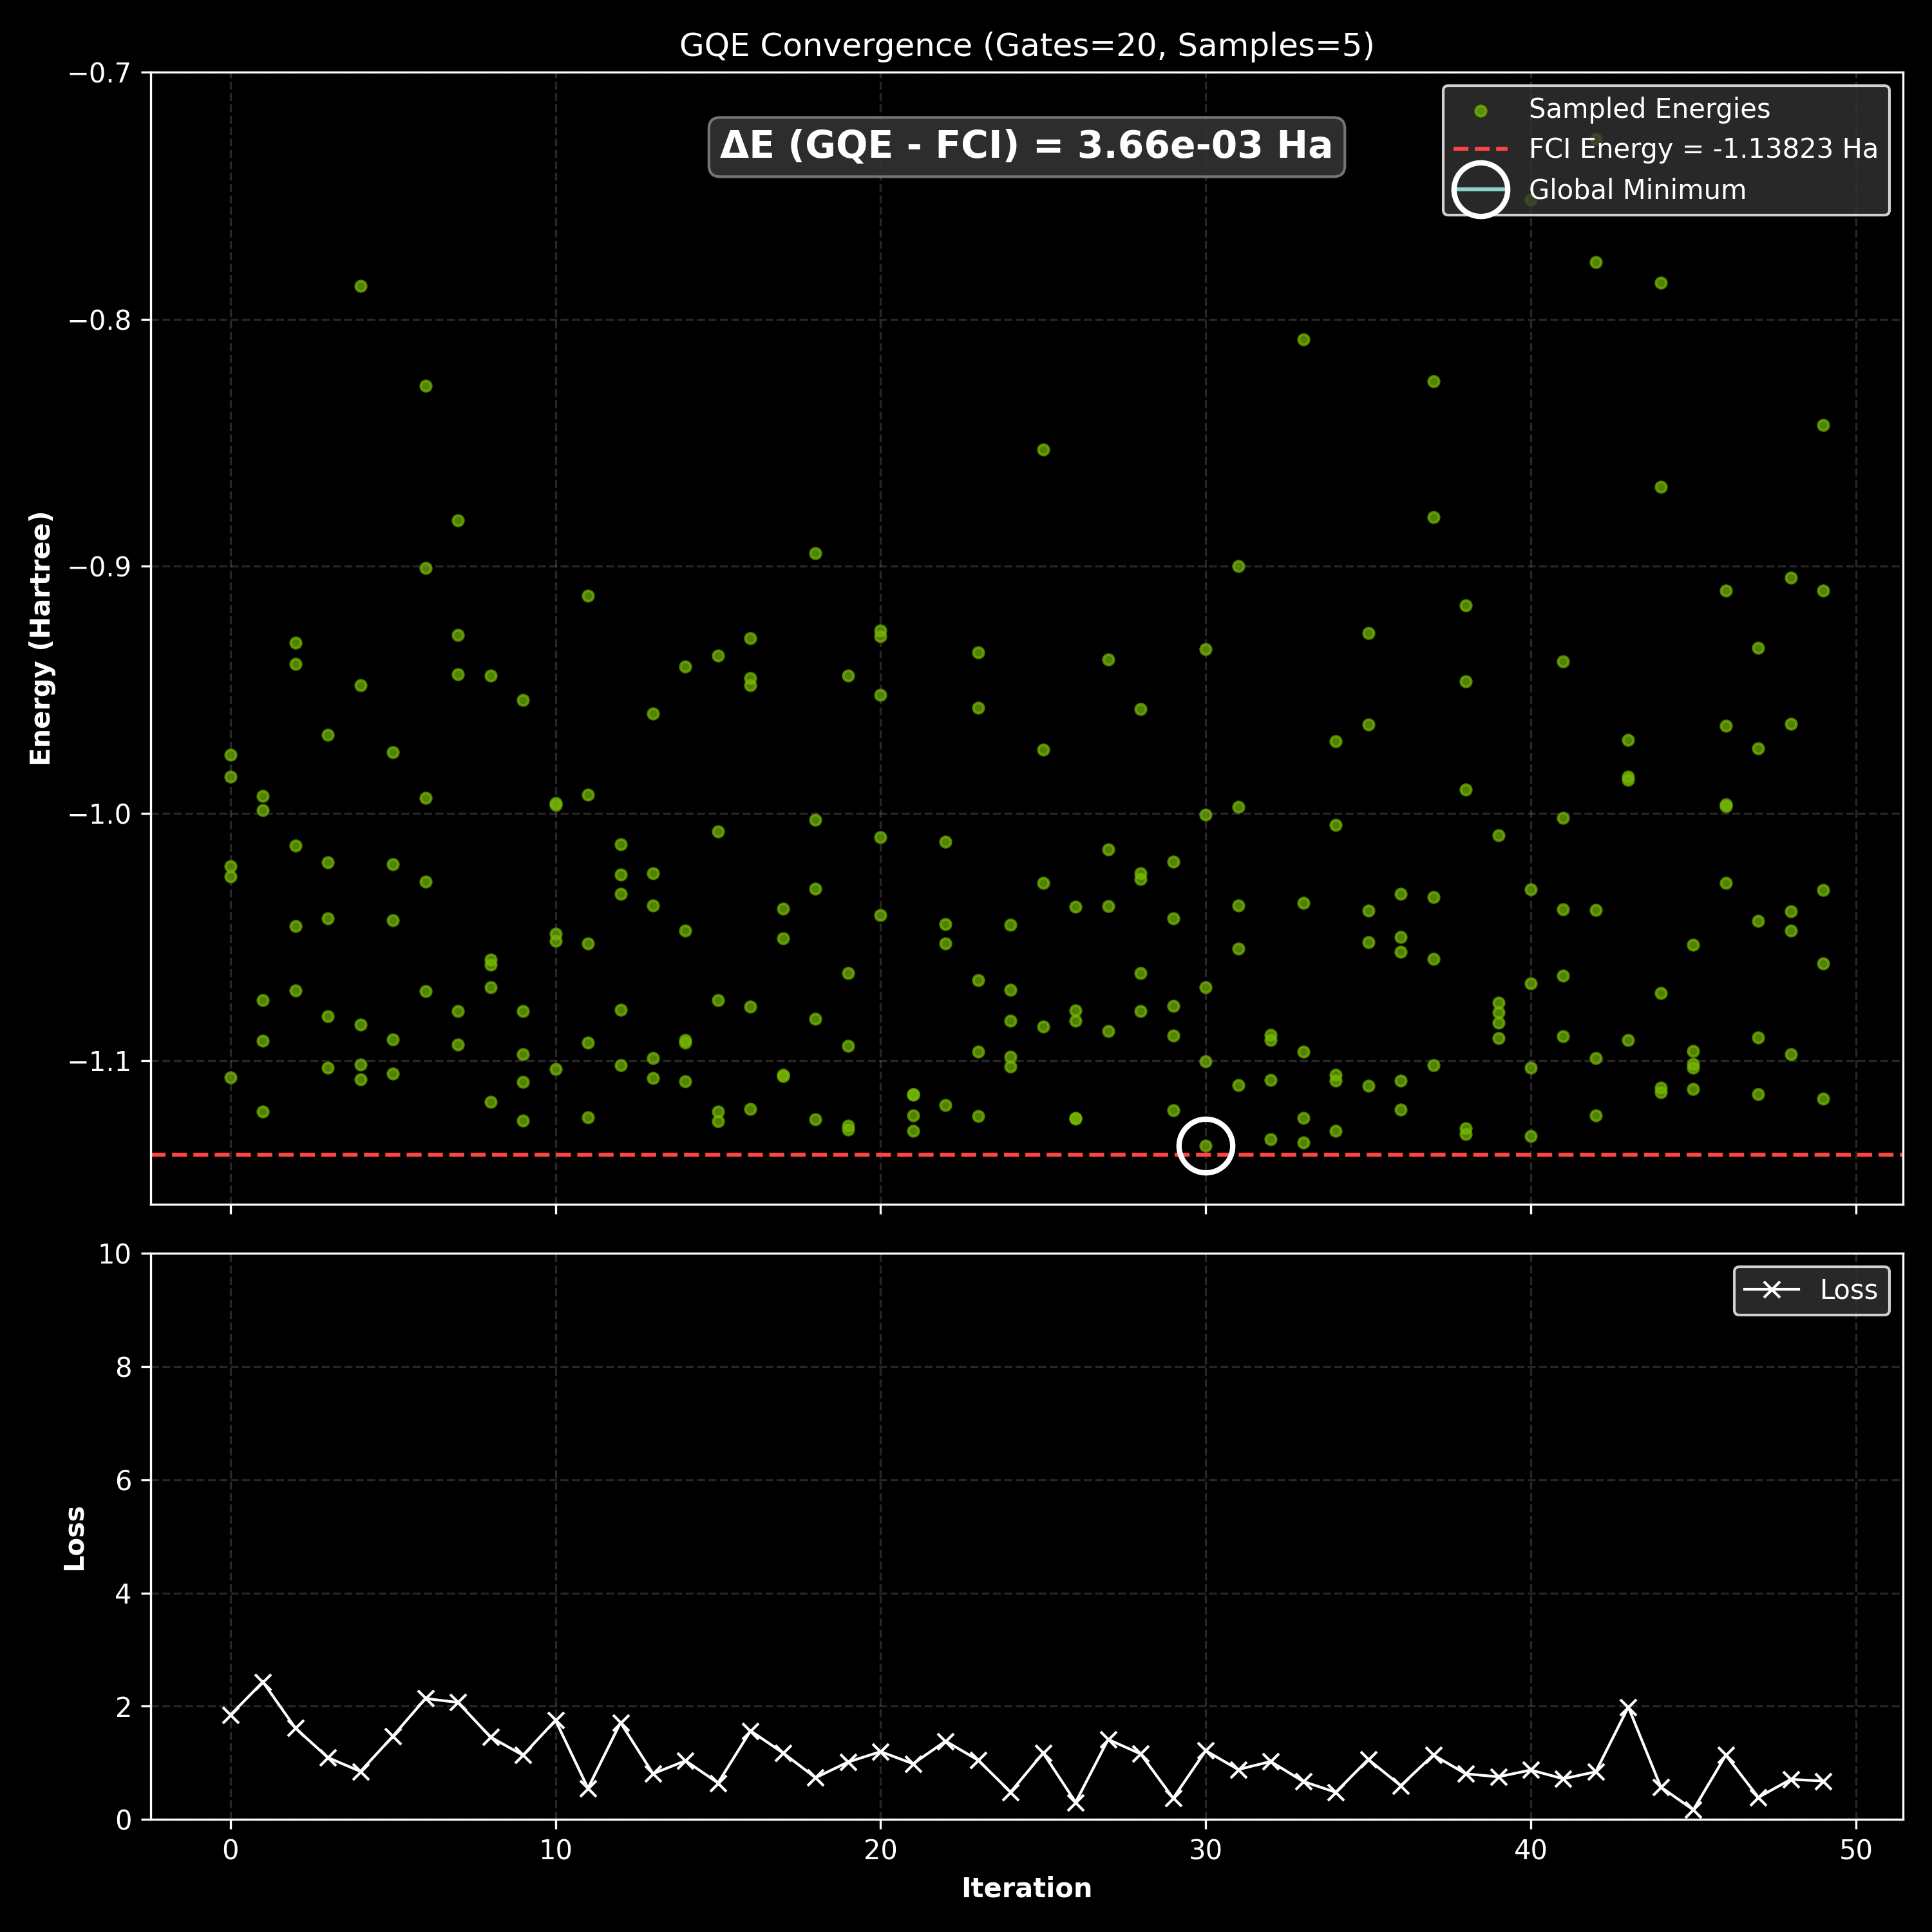

In [7]:
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 5 --lr 1e-7 --temperature 5.0 --output_file 'baseline.png'
display(Image(filename='baseline.png', width=600))

A few things to notice.  First, the final energy produced by the routine may not correspond to any of the circuits sampled in the final epoch.  This is because every epoch, 5 circuits are sampled and their energies measured. The final result is the lowest energy found from all  50 * 5 circuits sampled, even if it was found in an earlier epoch! In the instance above, that is epoch 36.  

In theory, as the model trains, it samples better circuits, but the process is training a distribution so it is not garunteed the best solution will be sampled at any particular epoch. This can somewhat be observed as the samples get generally lower in energy.  The training loss function below shows that the model is indeed training and would probably get even better if we let it run longer. 

Also note that the data is output in a folder called `gqe_logs` which creates a JSON file with all of the data. Each epoch produces sets of index values that looks like this. 

$$[324, 205, 0, 324, 205, 135, 258, 221, 190, 205, 233, 146, 236, 324, 376, 31, 205, 135, 324, 461]$$ 

This specifies a circuit which is constructed by adding operator 324 then 205, and so on based on the operators in the vocabulary. Each circuit has an associated energy saved too.

A final observation, note how many parameters are trained, over 86 million!

### Exploring Sample Size

Sample size is another key choice. Consider how sample size will impact the training and results. What is the downside to a higher sample count?  Try running with only 2 samples and then with 30. 

In [8]:
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 2 --lr 1e-7 --temperature 5.0 --output_file 'sample_small.png'
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 100 --lr 1e-7 --temperature 5.0 --output_file 'sample_large.png'


Full CI Energy (R-CASCI): -1.1382282118692273
Configuration: max_iters=50, ngates=20, num_samples=2, temperature=5.0
Seed set to 3047
total trainable params: 86.21M
epoch 0 loss tensor(2.3065, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.9326050281524658 tensor(-1.0214)
epoch 1 loss tensor(2.4970, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3184034824371338 tensor(-1.0756)
epoch 2 loss tensor(1.2487, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.31224584579467773 tensor(-1.0227)
epoch 3 loss tensor(2.0926, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.39687204360961914 tensor(-1.0197)
epoch 4 loss tensor(1.7064, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3099088668823242 tensor(-1.0732)
epoch 5 loss tensor(0.2860, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32047152519226074 tensor(-1.1052)
epoch 6 loss tensor(2.9894, device='cuda:0', g

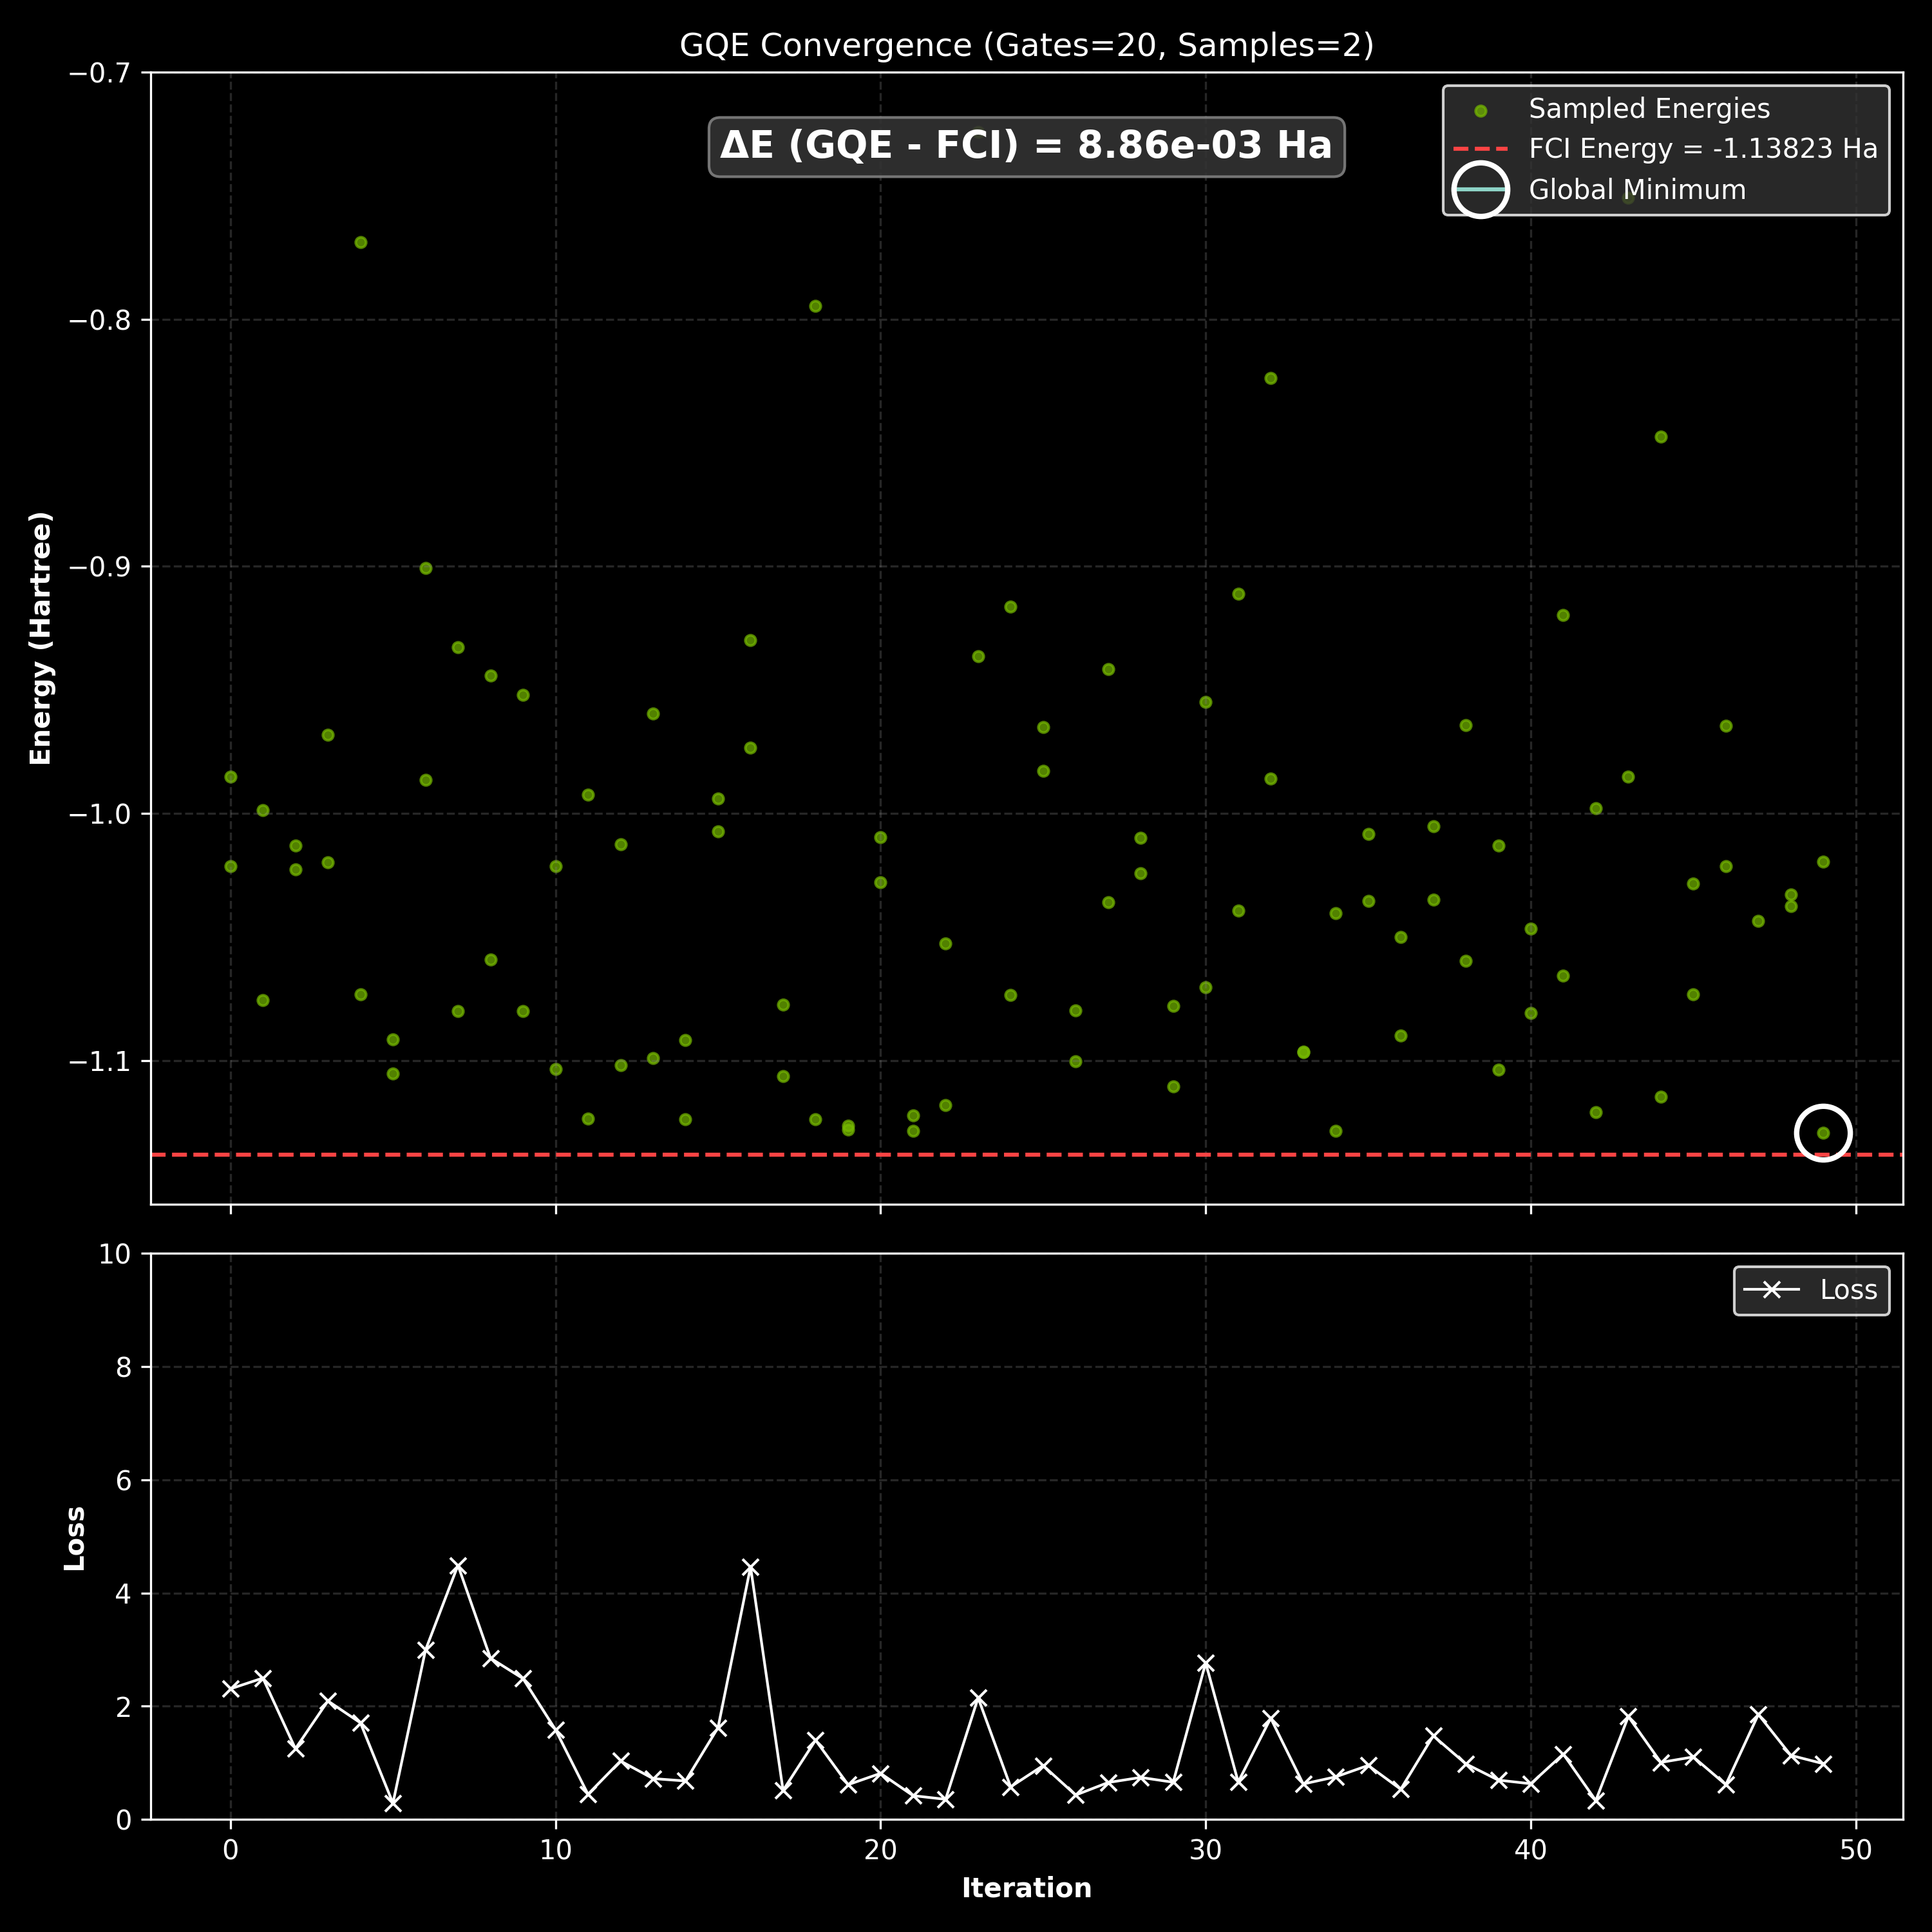

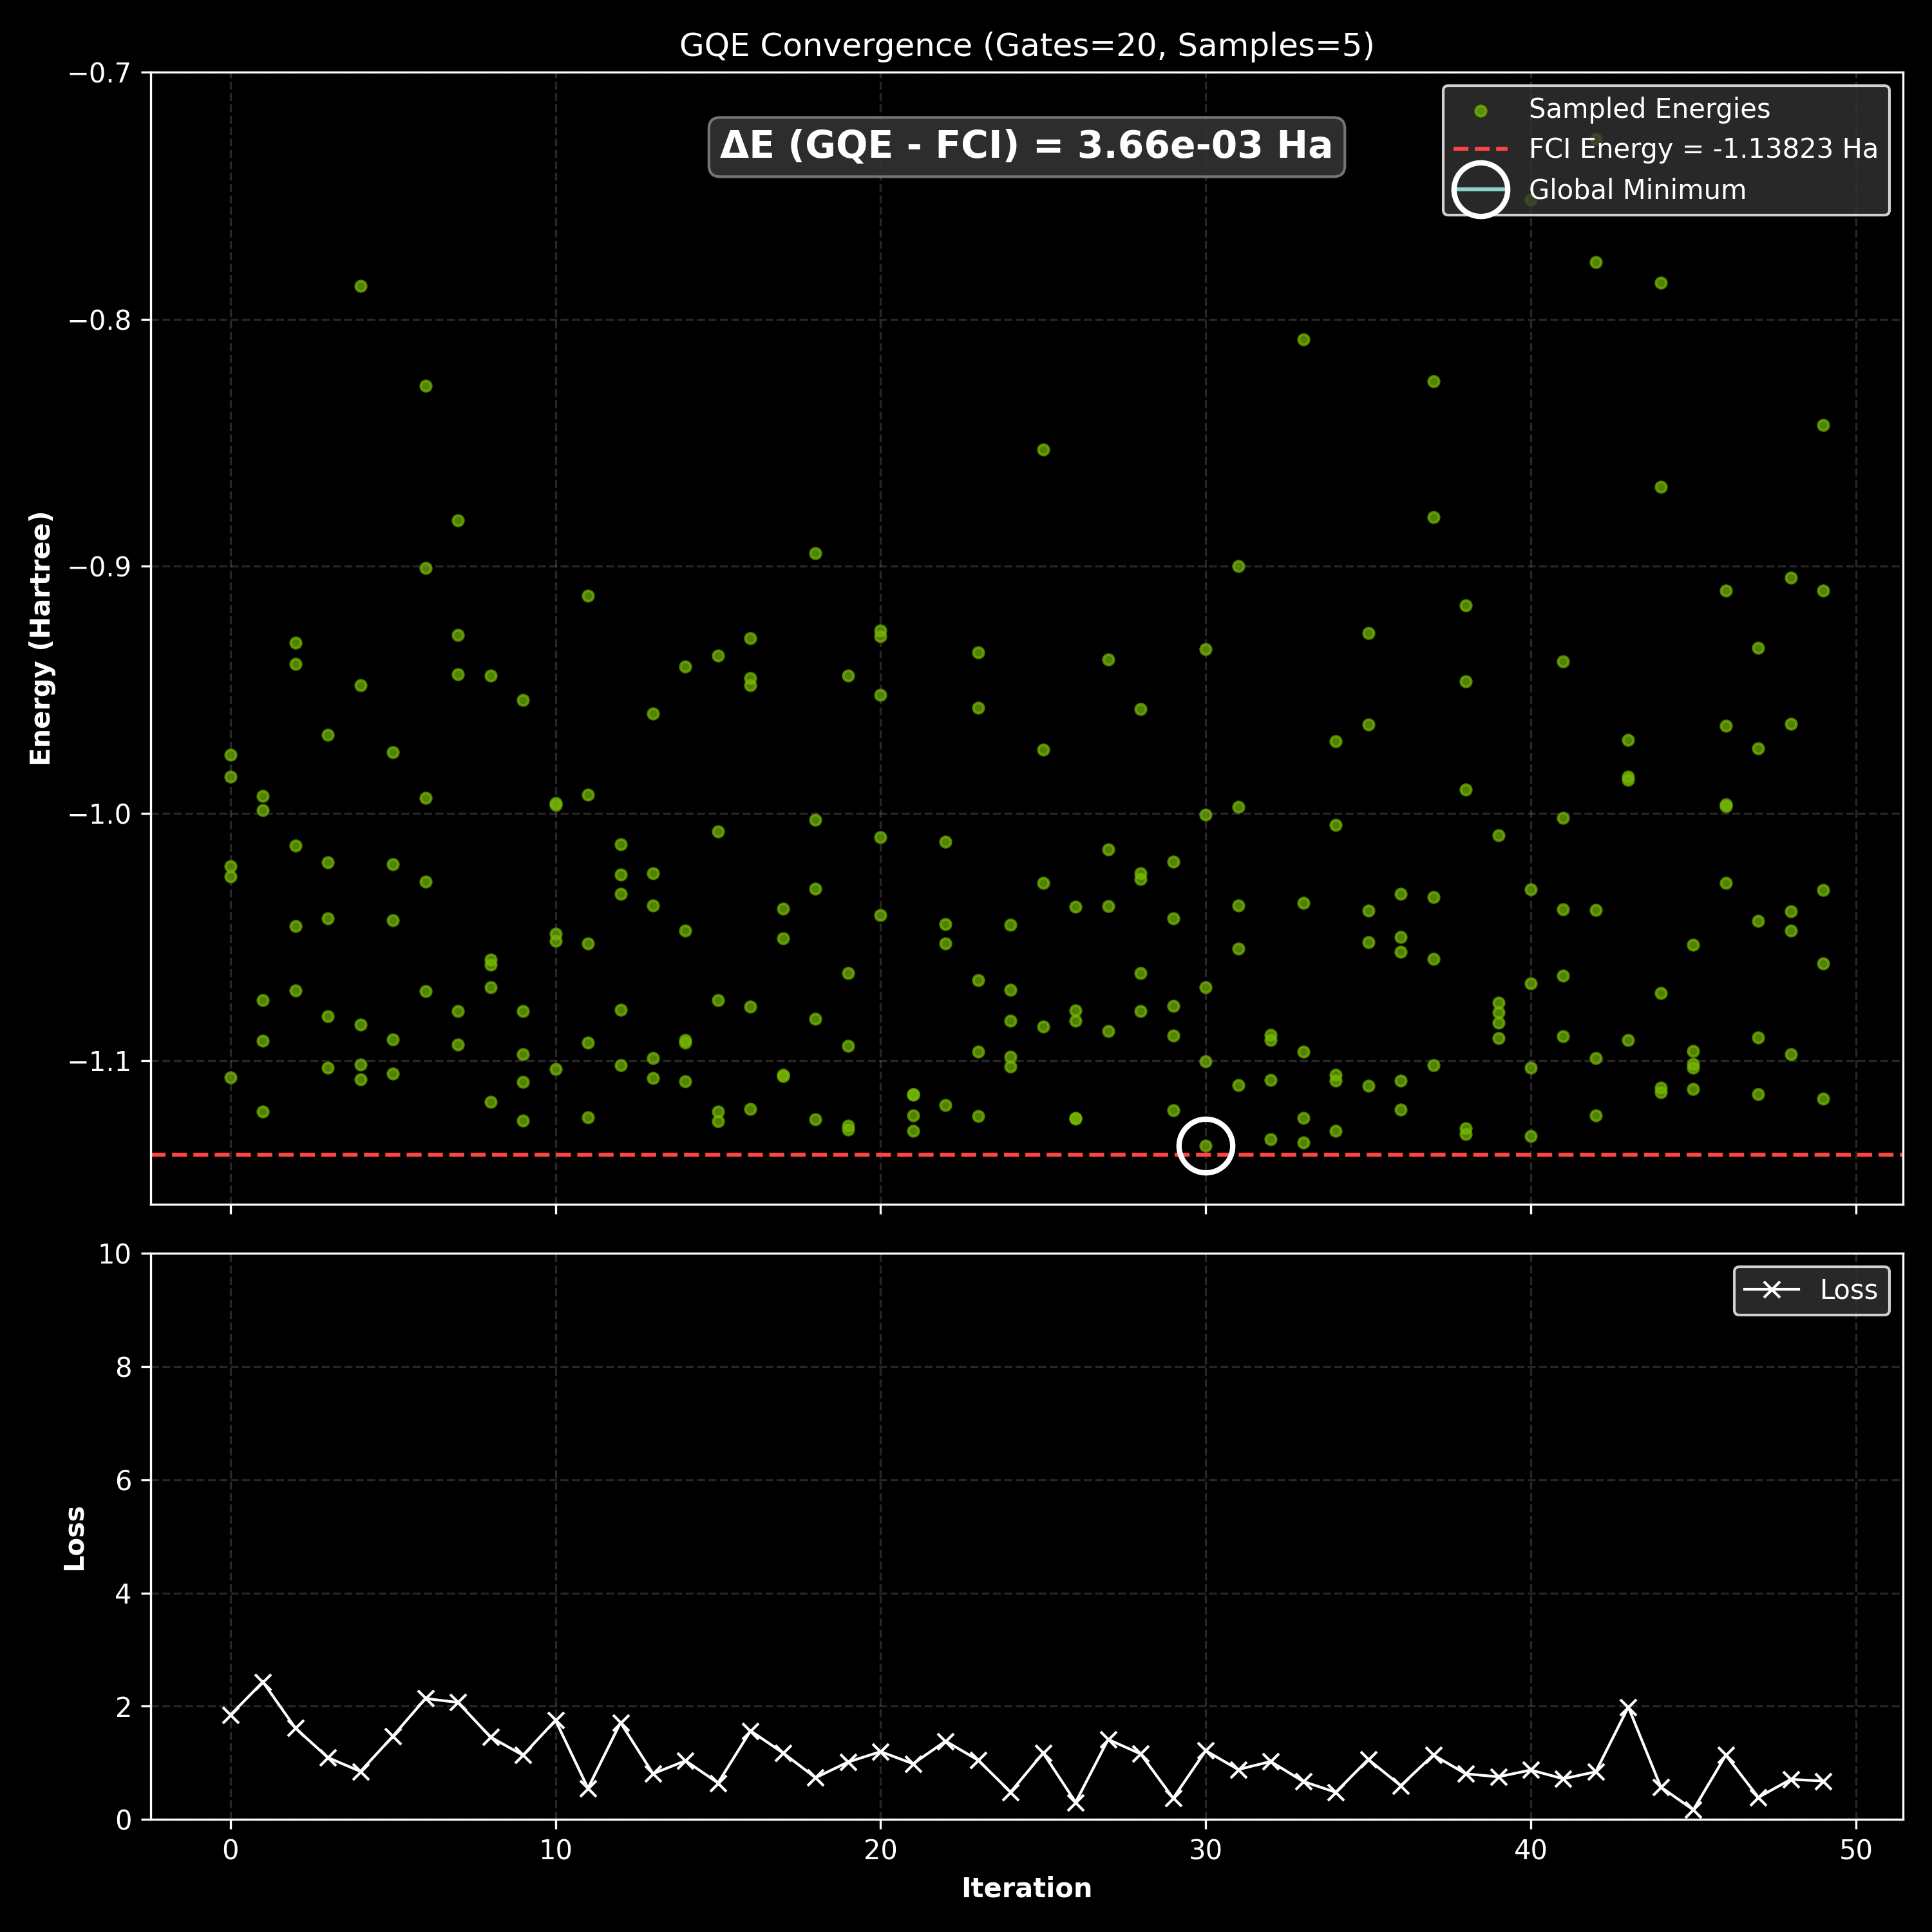

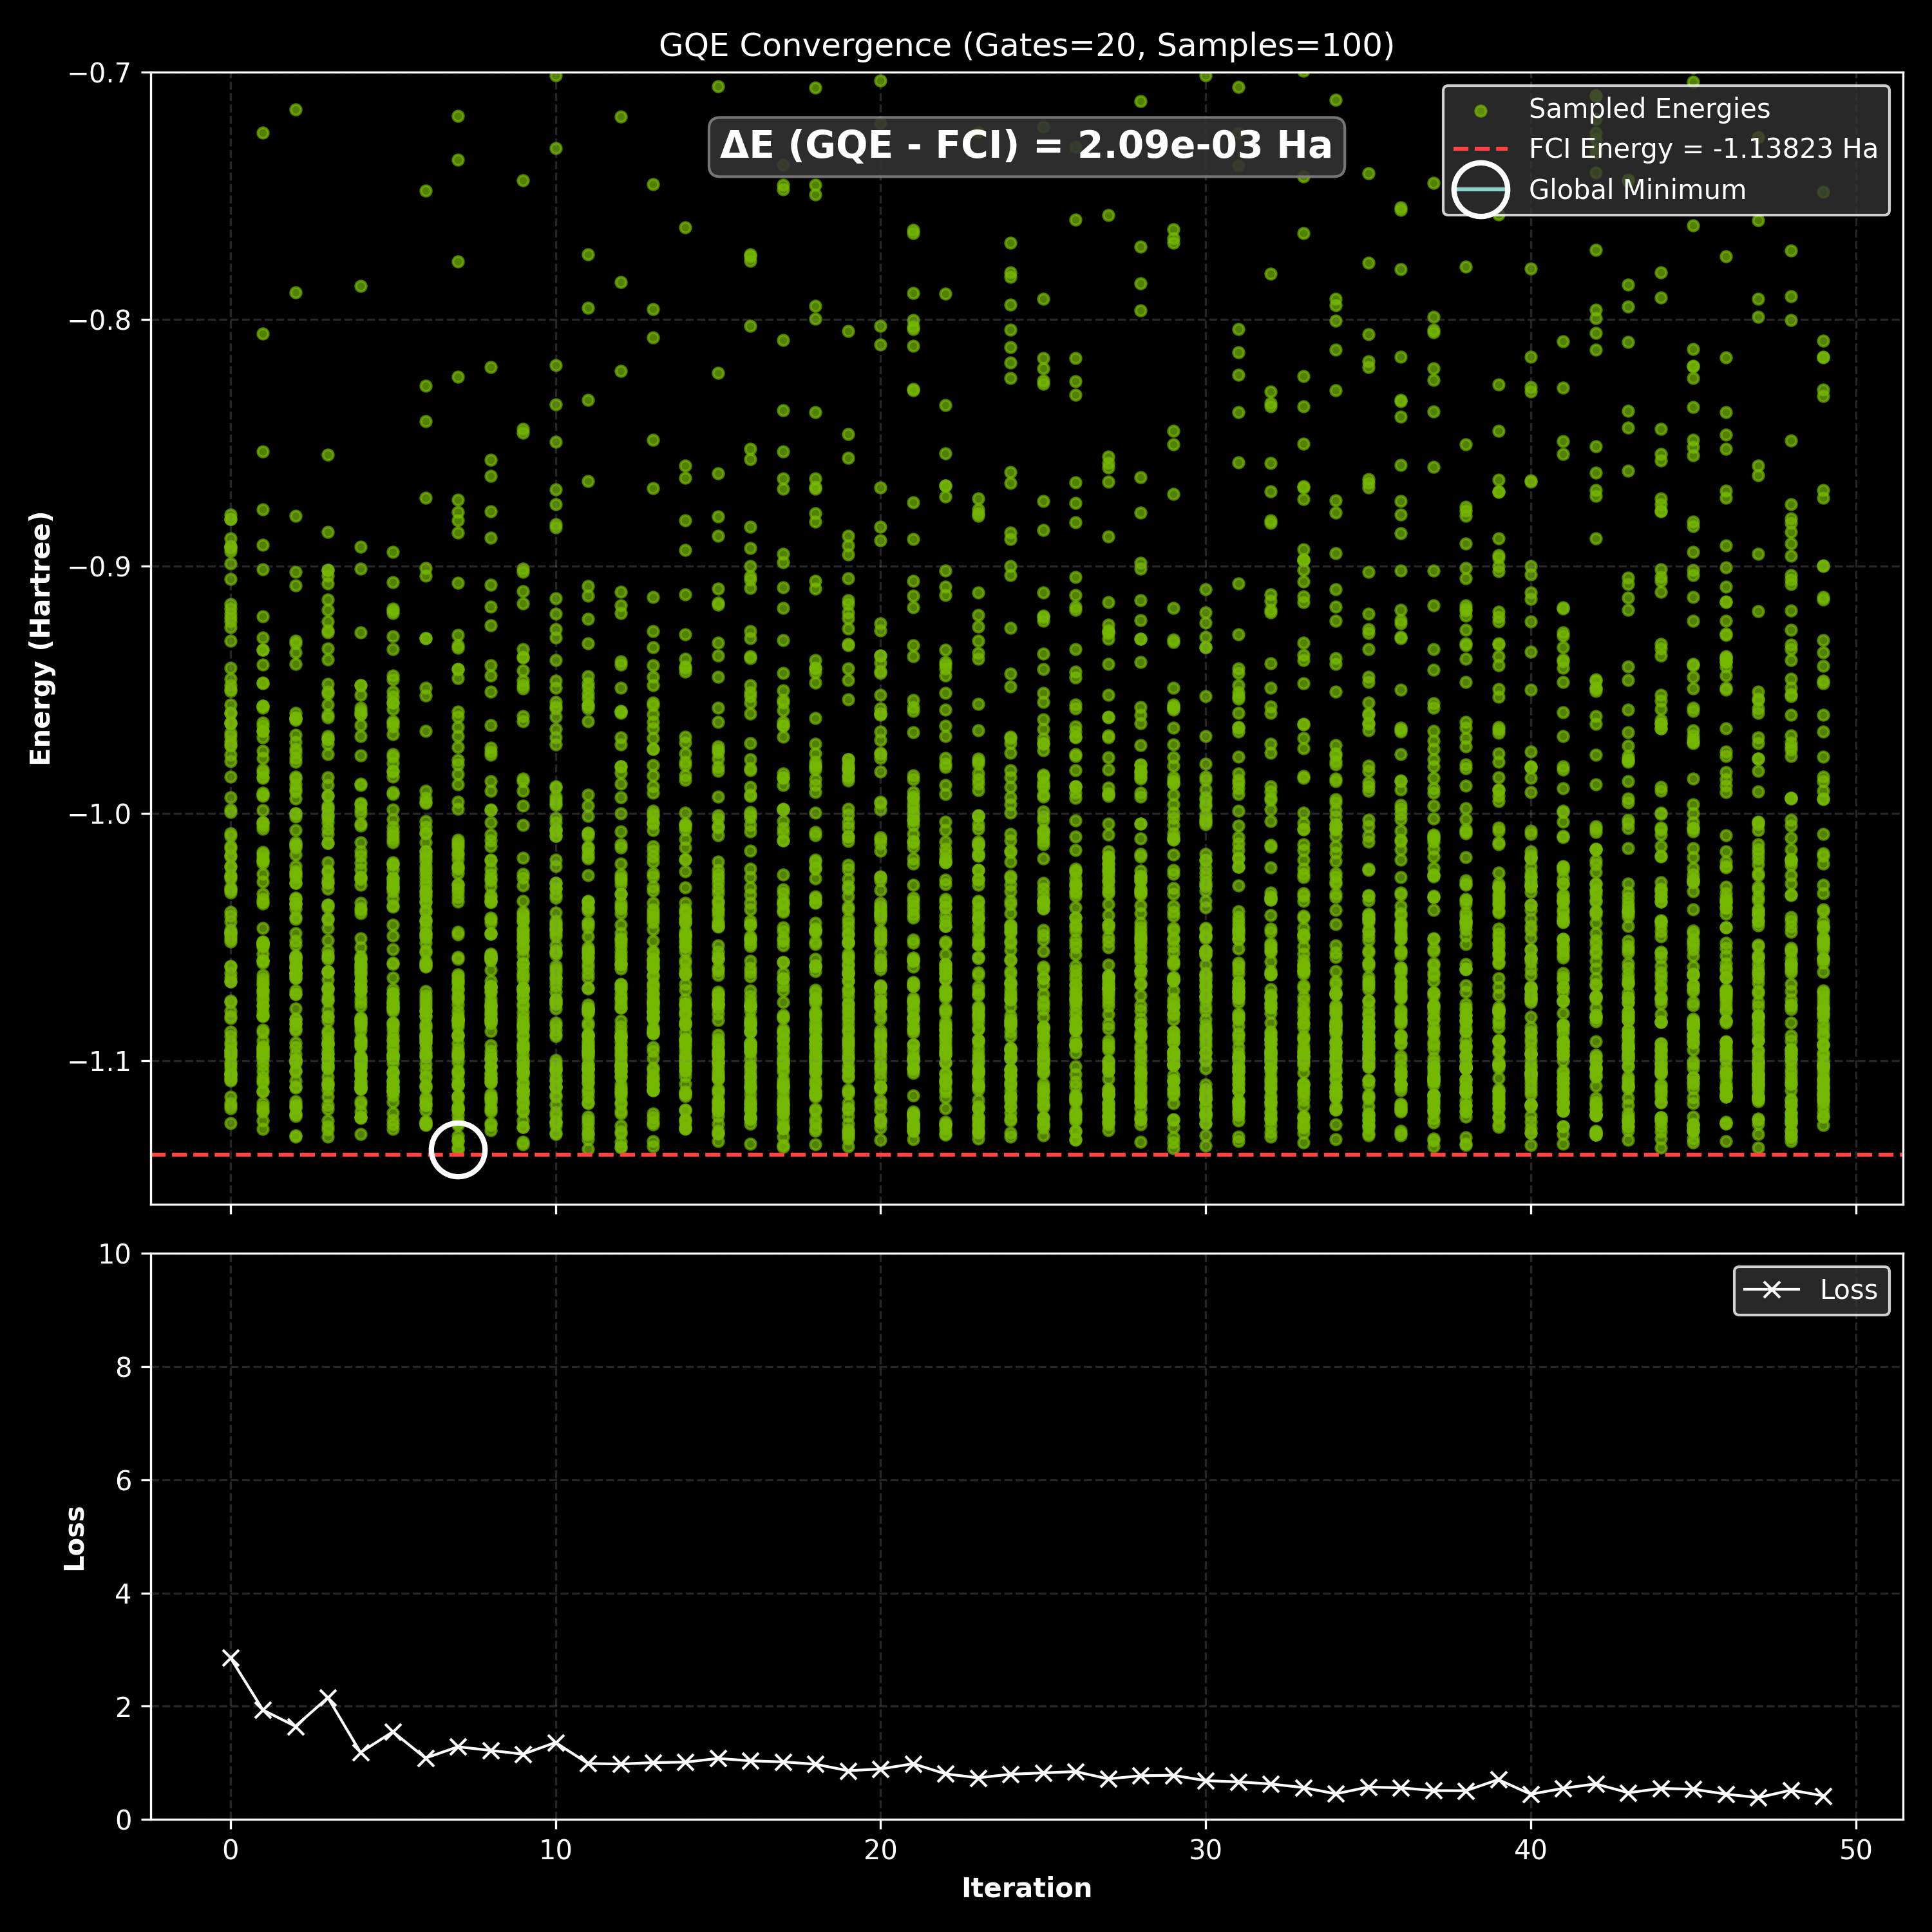

In [9]:
display(Image(filename='sample_small.png', width=700))
display(Image(filename='baseline.png', width=700))
display(Image(filename='sample_large.png', width=700))

The key observation here is the convergence of the loss function. Notice that with high samples, it convergences more smoothly compared to only two samples and results in a better overall result. This makes intuitive sense. If the goal is to train a distribution, more samples will always provide a better representation of what is being trained.  The tradeoff is that more samples require more QPU time. So users must account for the resources they have available for training. Look at the timings shown for the training steps above. Notice how much longer it took to obtain 30 samples.  If this was a much larger circuit with more operators this would take even longer.

Thankfully, the GQE method can be easily parallelized and run every sample asynchronously at the same time on a different QPU or GPU.


### Exploring Gate Count

You can also set the gate count to specify how many operators are sampled for each circuit. Run a couple of cases below with a small and large number of operators/gates.  What problems might occur with too many or too few?



In [10]:
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 4 --num_samples 5 --lr 1e-7 --temperature 5.0 --output_file 'gates_small.png'
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 100 --num_samples 5 --lr 1e-7 --temperature 5.0 --output_file 'gates_large.png'


Full CI Energy (R-CASCI): -1.1382282118692275
Configuration: max_iters=50, ngates=4, num_samples=5, temperature=5.0
Seed set to 3047
total trainable params: 86.21M
epoch 0 loss tensor(7.8308, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.6441724300384521 tensor(-1.1273)
epoch 1 loss tensor(2.5940, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.07939934730529785 tensor(-1.1310)
epoch 2 loss tensor(1.1837, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.07961893081665039 tensor(-1.1259)
epoch 3 loss tensor(1.5254, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.08134841918945312 tensor(-1.1219)
epoch 4 loss tensor(1.4864, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.08054208755493164 tensor(-1.1258)
epoch 5 loss tensor(1.7487, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.0797119140625 tensor(-1.1243)
epoch 6 loss tensor(3.0690, device='cuda:0', grad

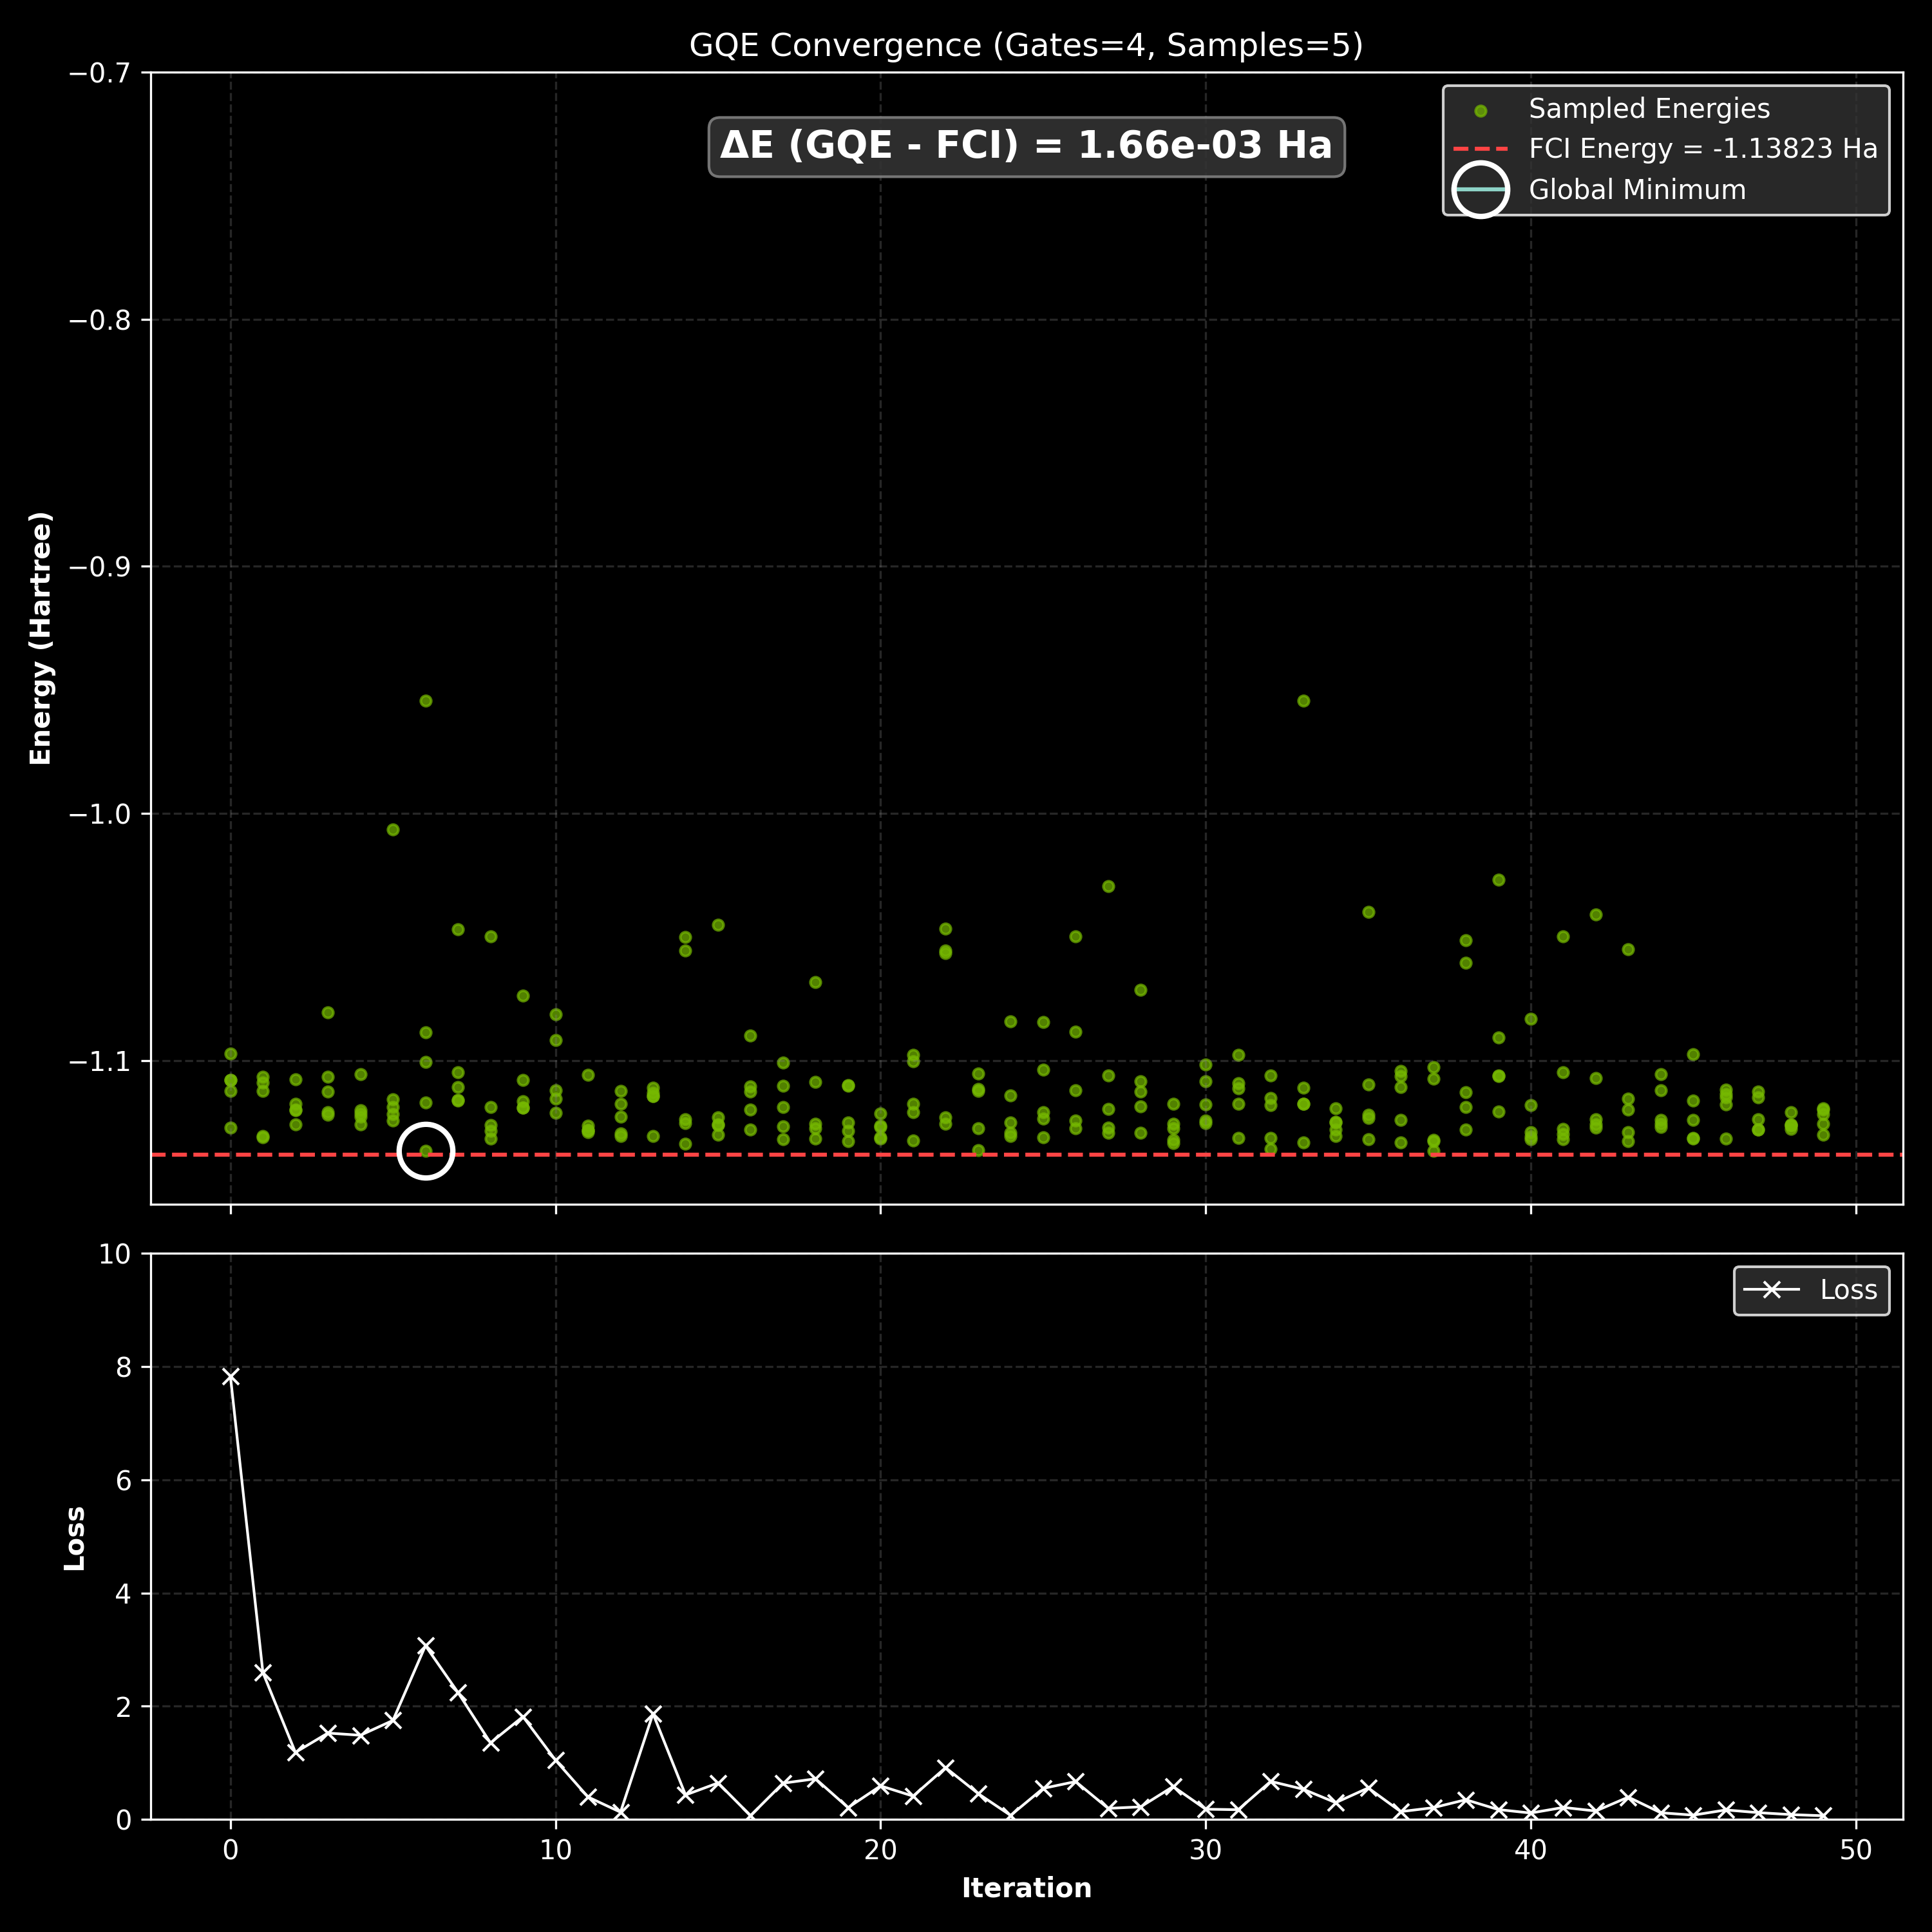

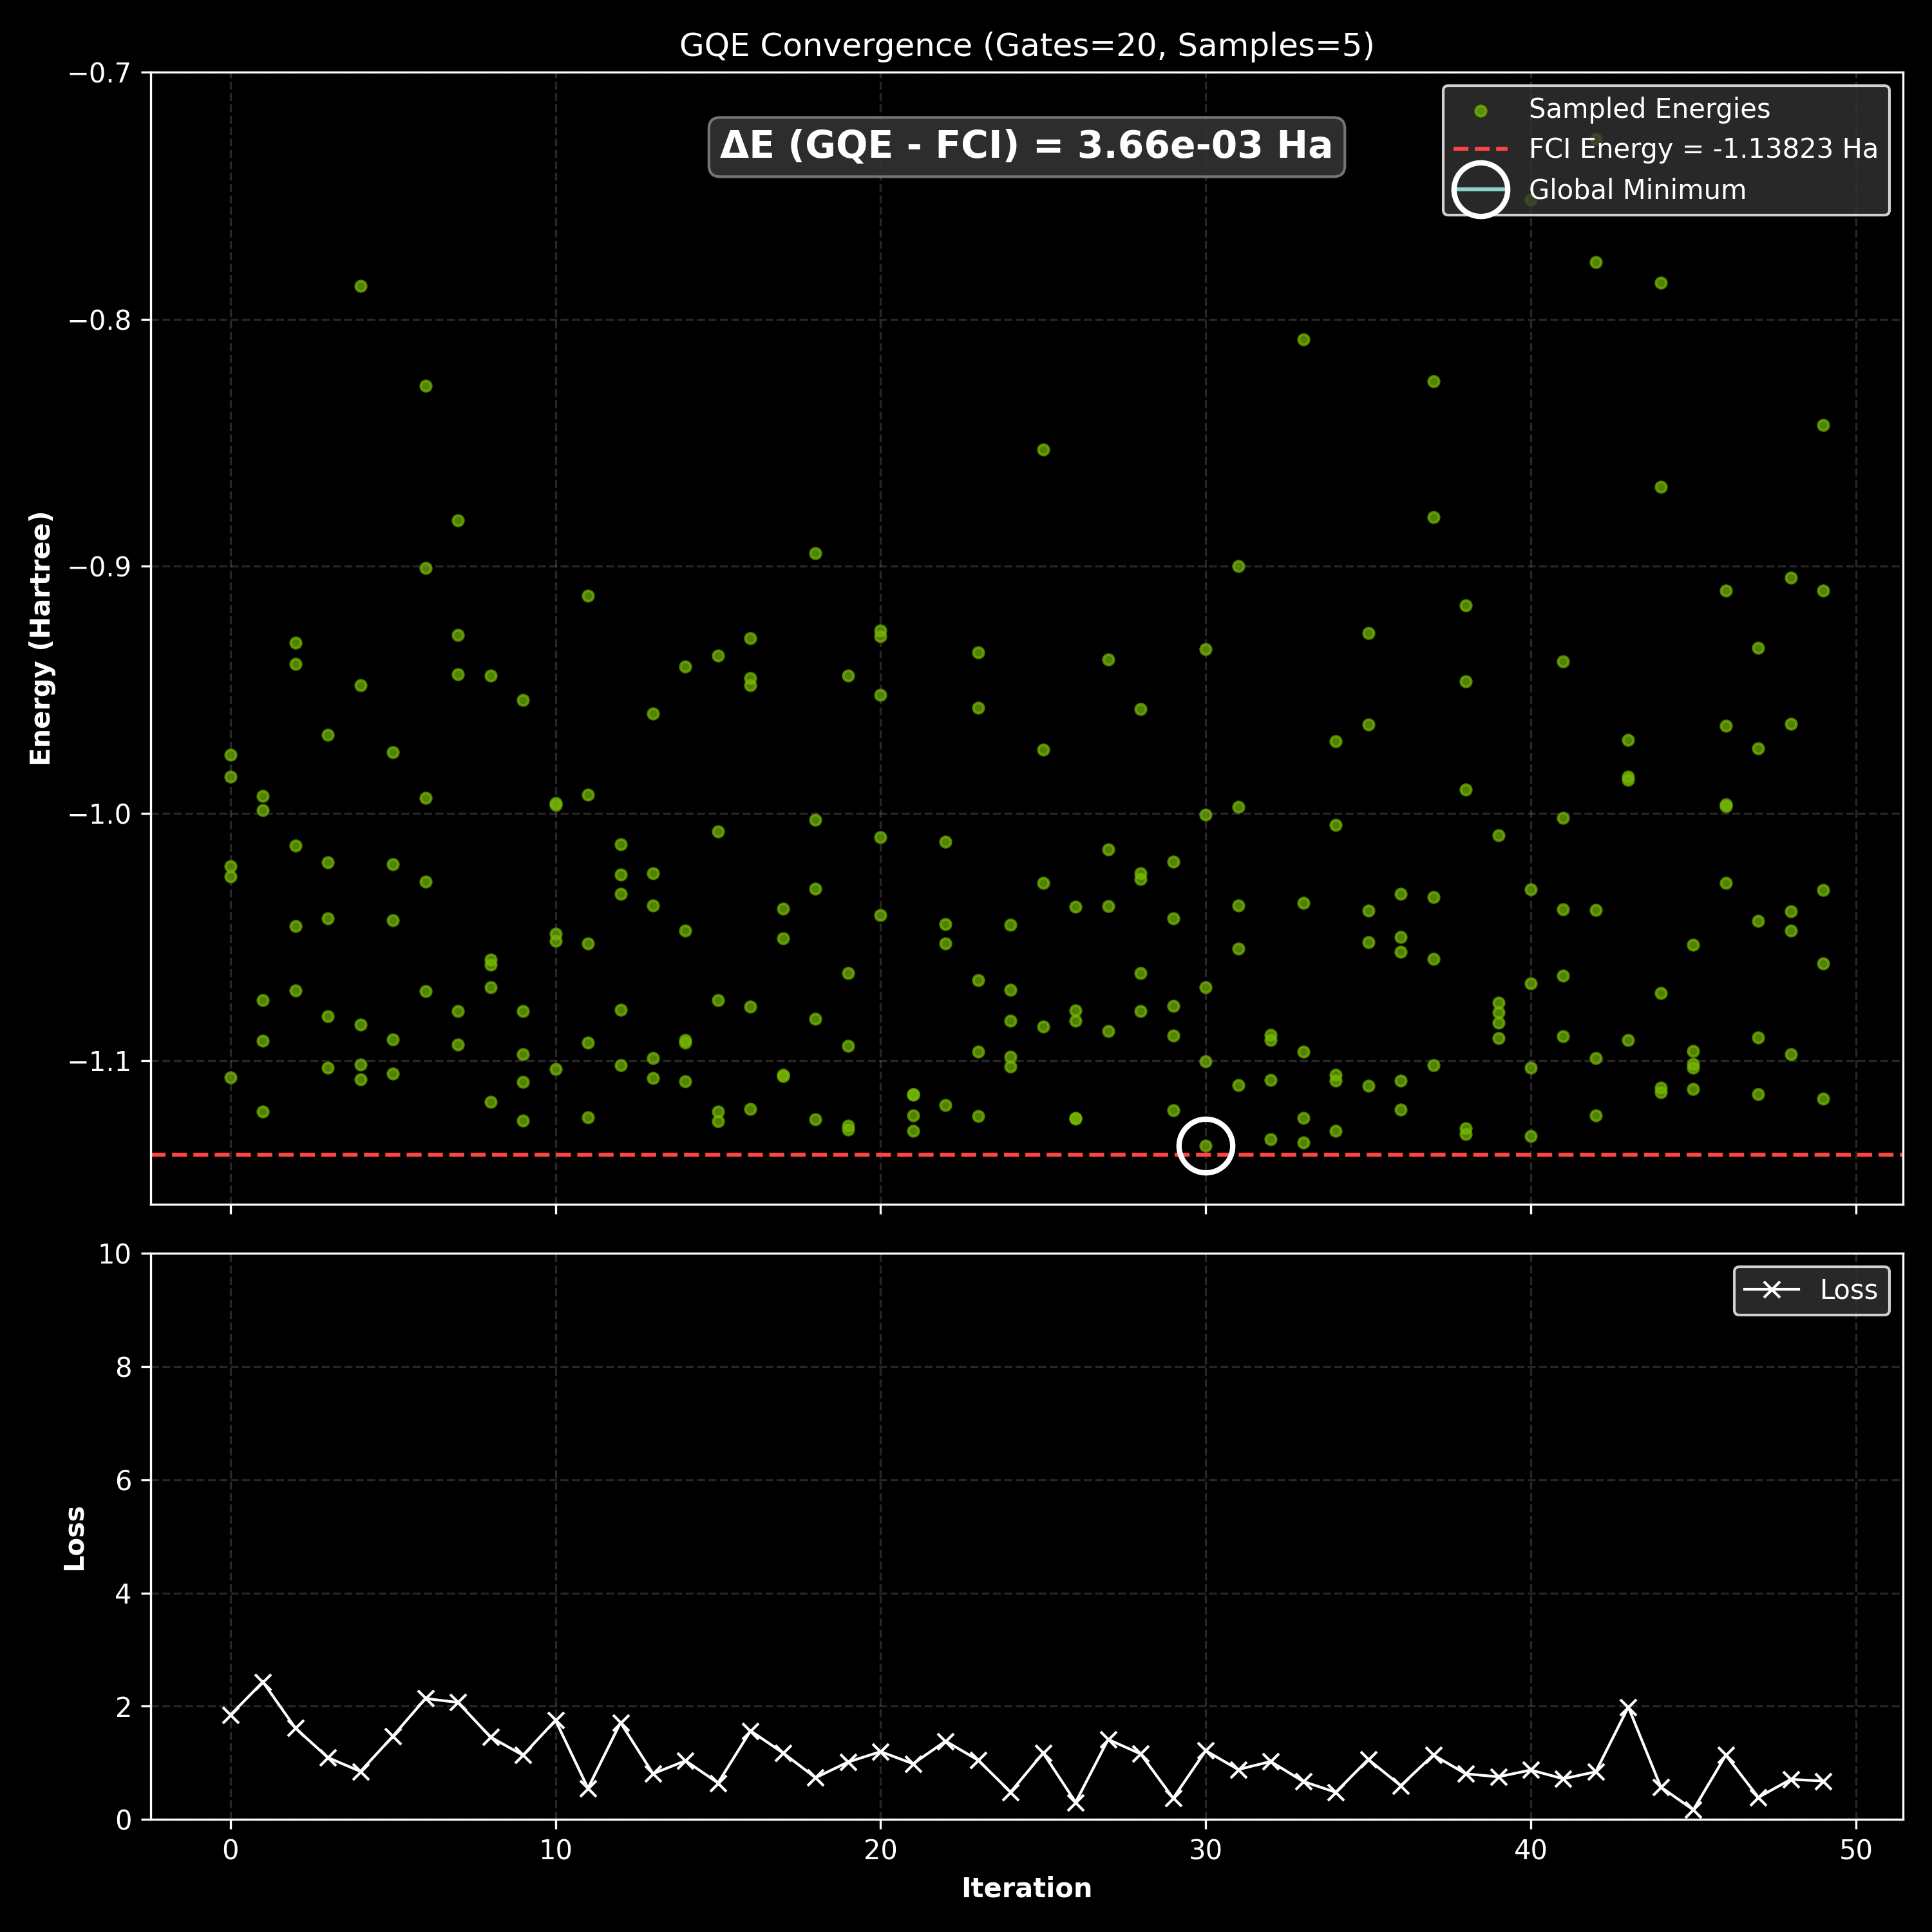

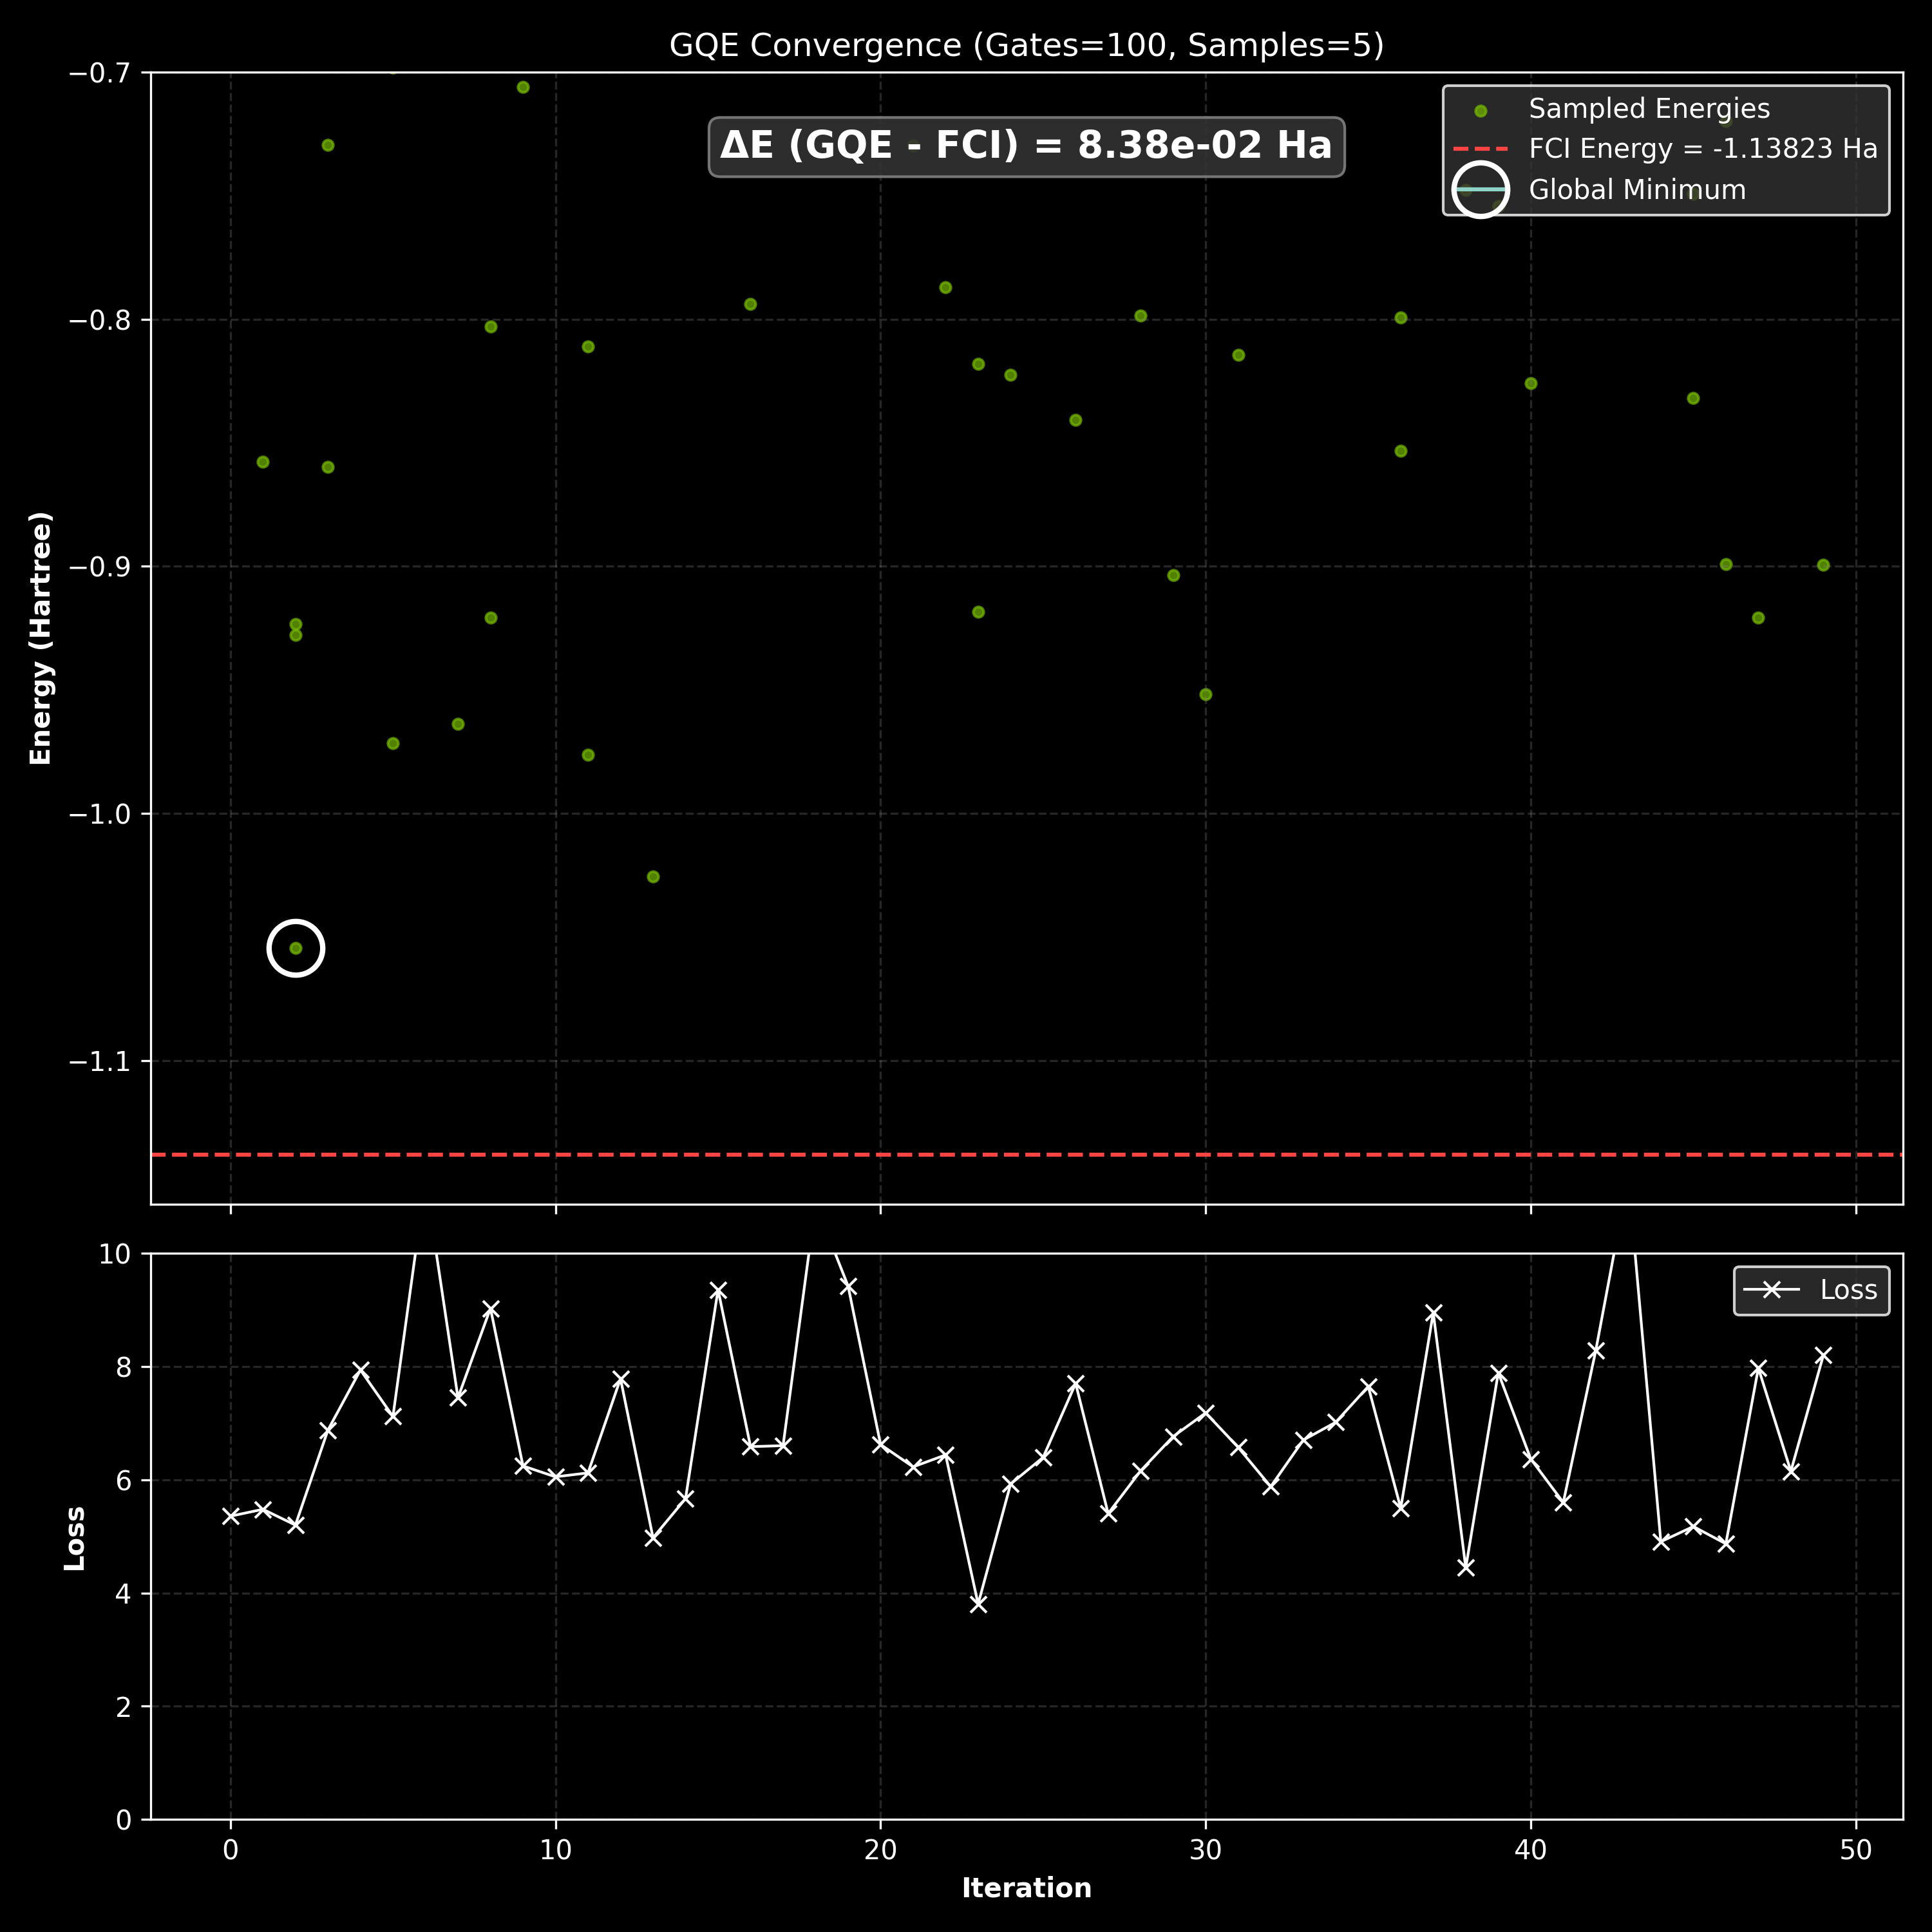

In [11]:
display(Image(filename='gates_small.png', width=600))
display(Image(filename='baseline.png', width=600))
display(Image(filename='gates_large.png', width=600))

You might have thought that more gates would improve the results, but in this case, it is the opposite. It is true that more gates provide more flexibility, but it also becomes harder to learn.  Notice how the loss function is much less converged with 100 gates. This may improve with more iterations, but it also might mean that there is some overfitting going on and we do not require as many gates to construct a good wavefunction.

It might also be the case that our vocabulary is the limiting factor and changing the operator pool is the fix.

Note that for more complex systems, too few gates can easily be a problem. If the circuits do not have enough flexibility to describe the entanglement structure of the wavefunction, poor results are guaranteed.

### Exploring Temperature

We can explore what happens when we change some of the settings.  A few cautions though.  First, the model training and sampling process is stochastic so any change we make is not garunteed to repeat what we observe. Our goal is to make some general observations about the impacts of changing hyperparameters like temperature and number of samples.  For our purposes, a fixed seed is used so the results are reproducible.

First try increasing the temperature to 30.  What do you expect to see? Also try running a case which a much lower temperature of 0.5. 

In [12]:
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 5 --lr 1e-7 --temperature 0.5 --output_file 'low_temp.png'
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 5 --lr 1e-7 --temperature 30 --output_file 'high_temp.png'

Full CI Energy (R-CASCI): -1.1382282118692277
Configuration: max_iters=50, ngates=20, num_samples=5, temperature=0.5
Seed set to 3047
total trainable params: 86.21M
epoch 0 loss tensor(3.0069, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.9390077590942383 tensor(-1.1062)
epoch 1 loss tensor(2.7119, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.35878634452819824 tensor(-1.1184)
epoch 2 loss tensor(3.3380, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.35388779640197754 tensor(-1.0769)
epoch 3 loss tensor(2.7197, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.35685086250305176 tensor(-1.0839)
epoch 4 loss tensor(2.8372, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3578603267669678 tensor(-1.0980)
epoch 5 loss tensor(3.1696, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.360637903213501 tensor(-1.1166)
epoch 6 loss tensor(2.4319, device='cuda:0', gr

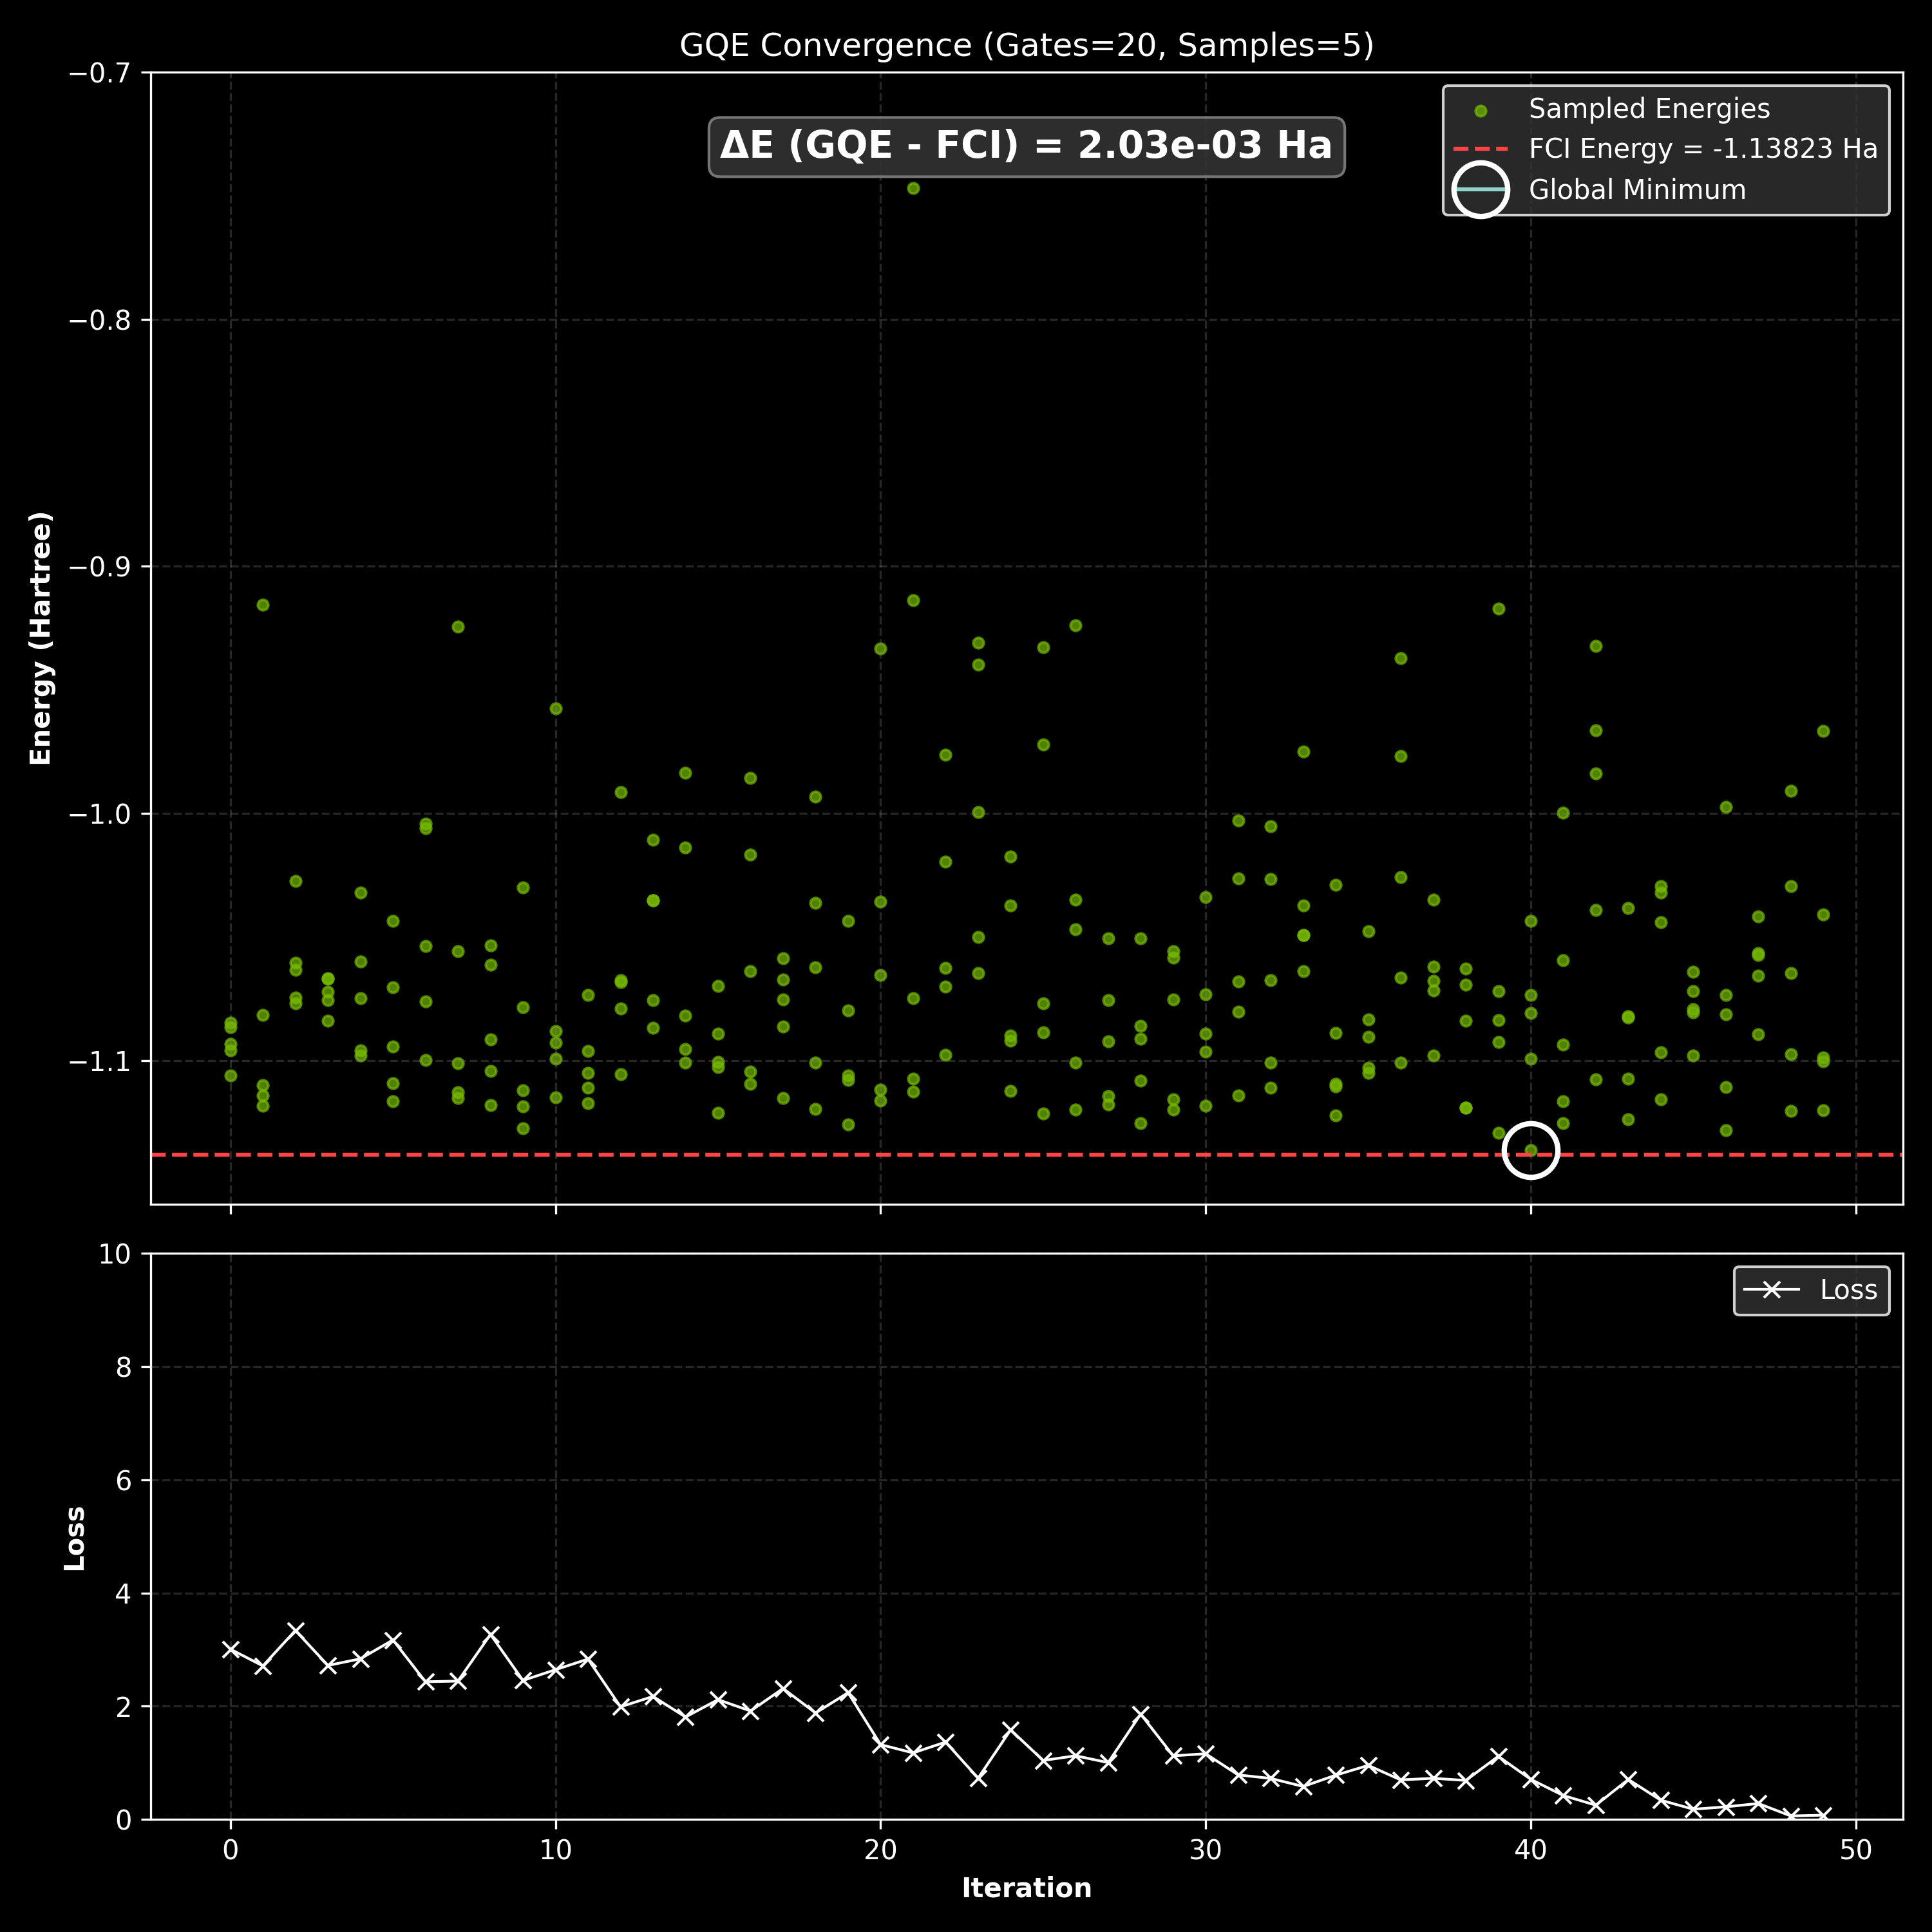

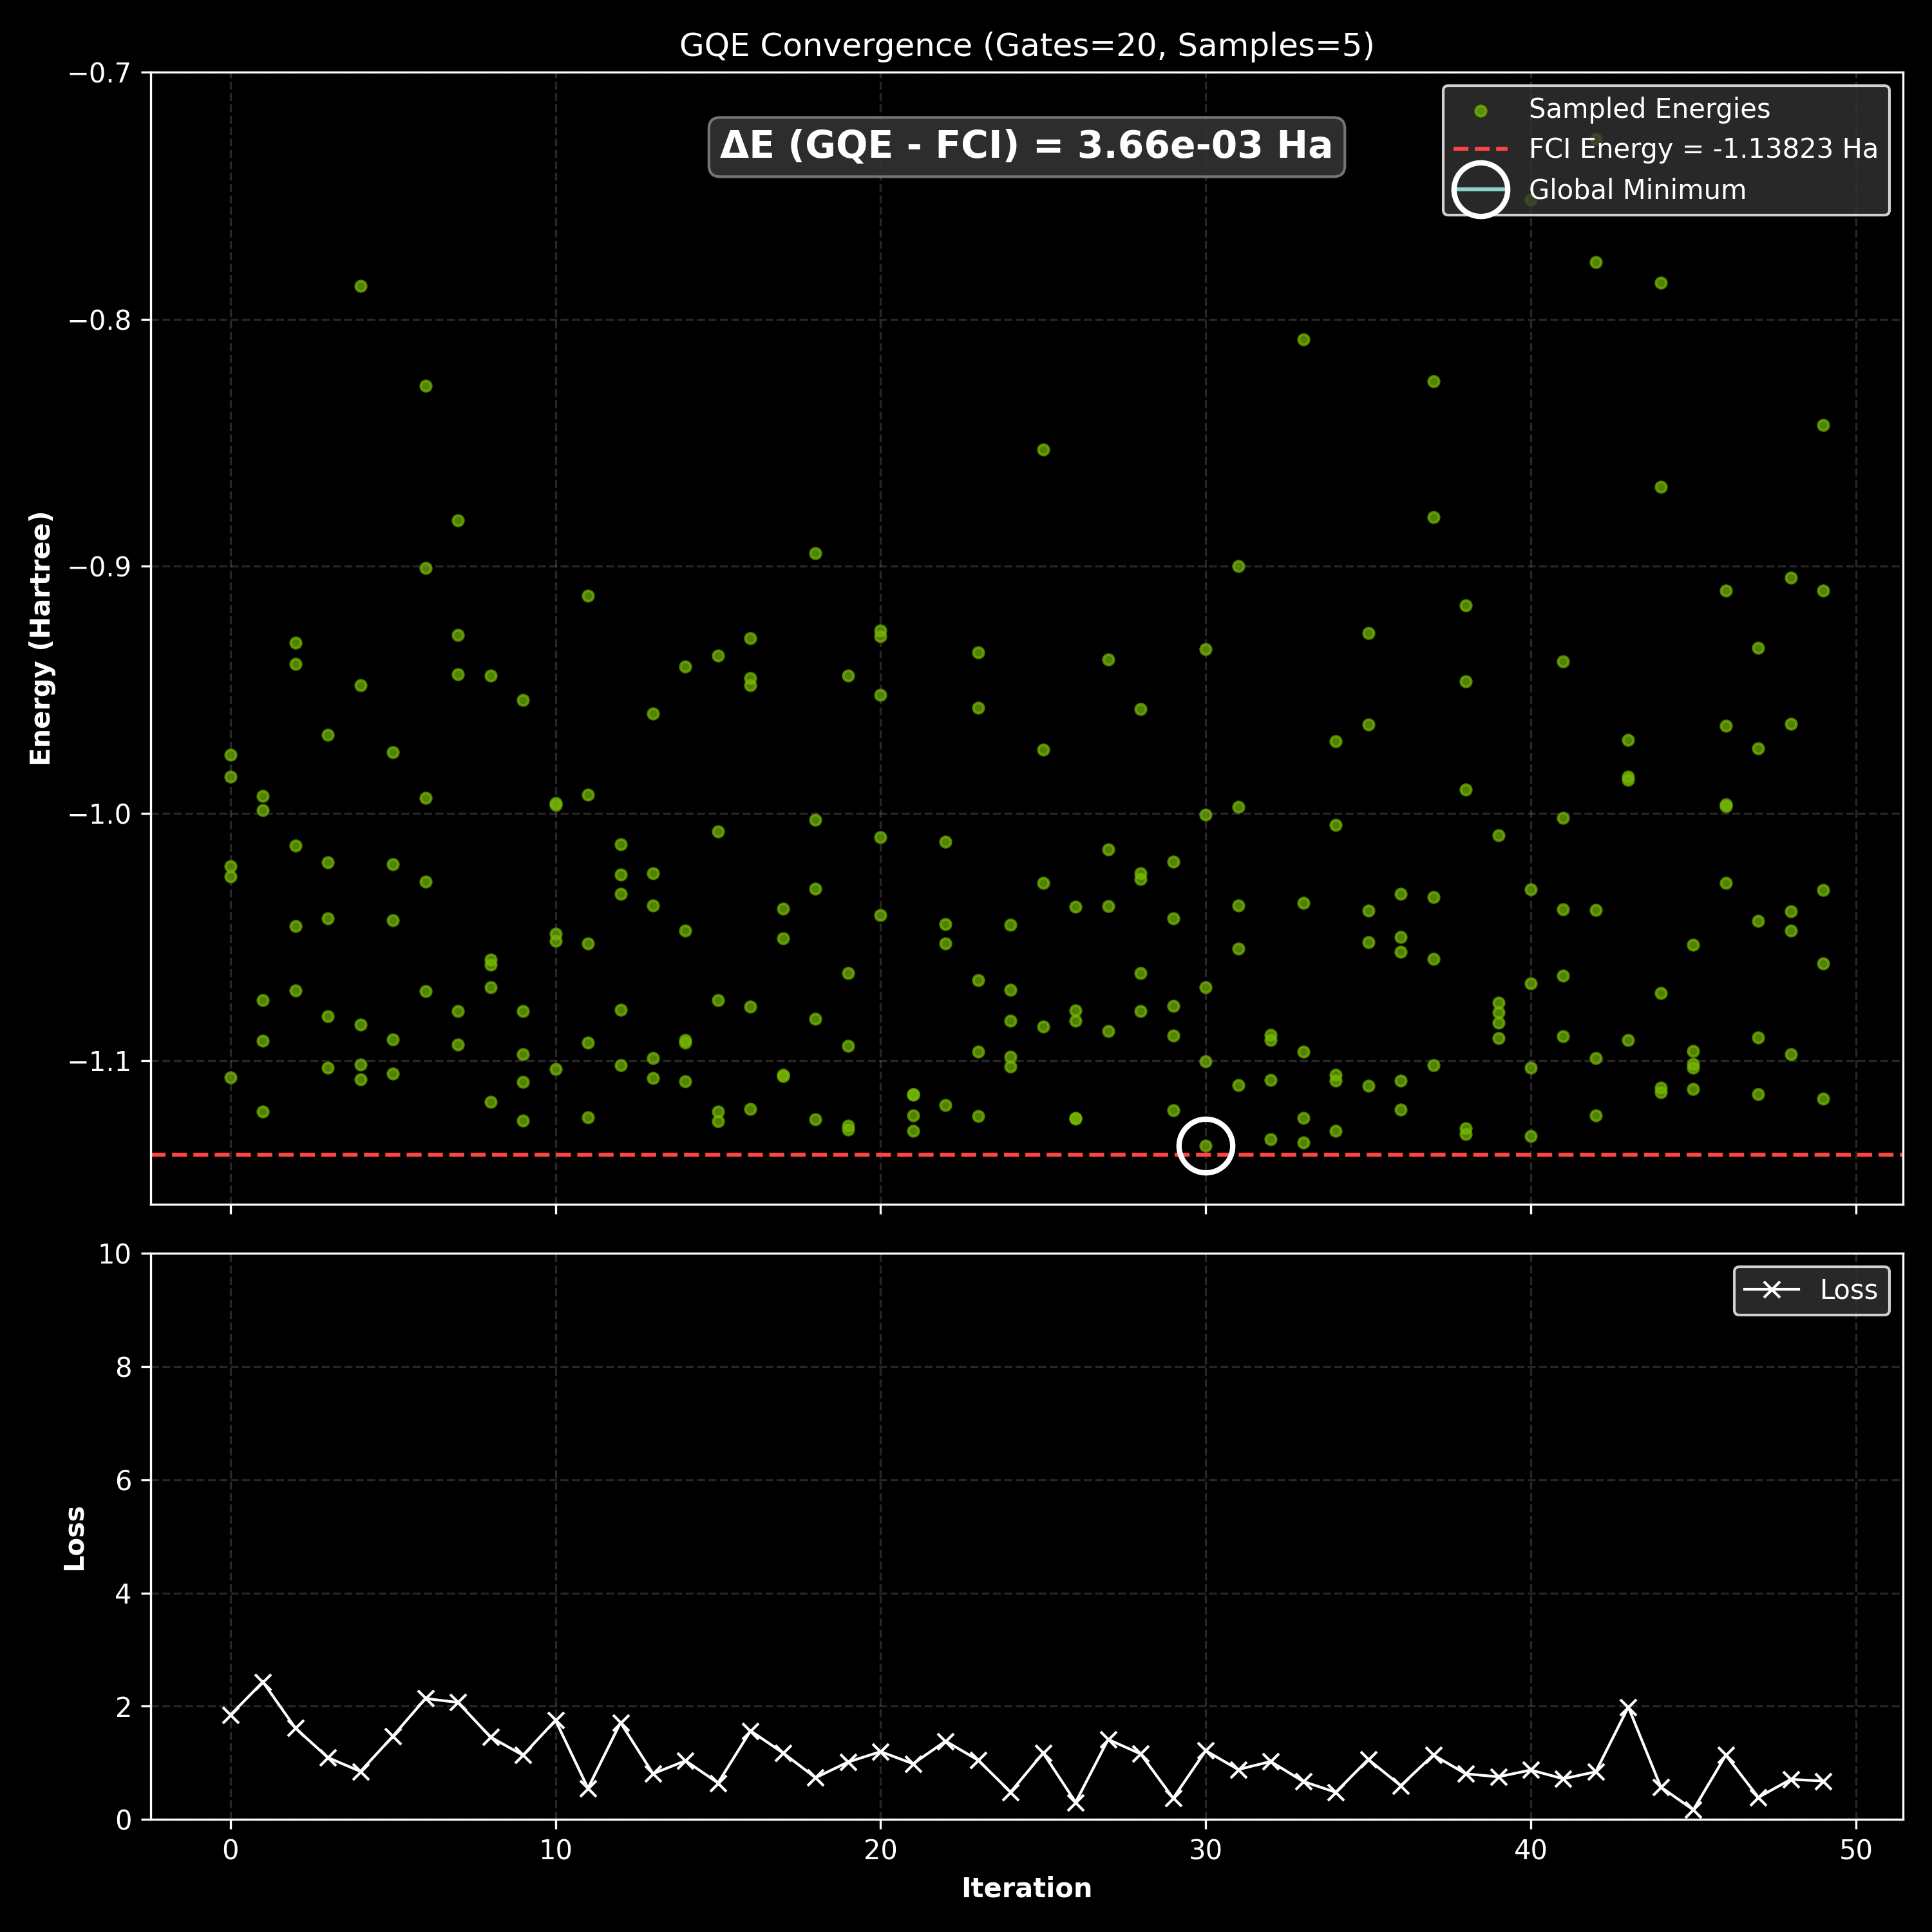

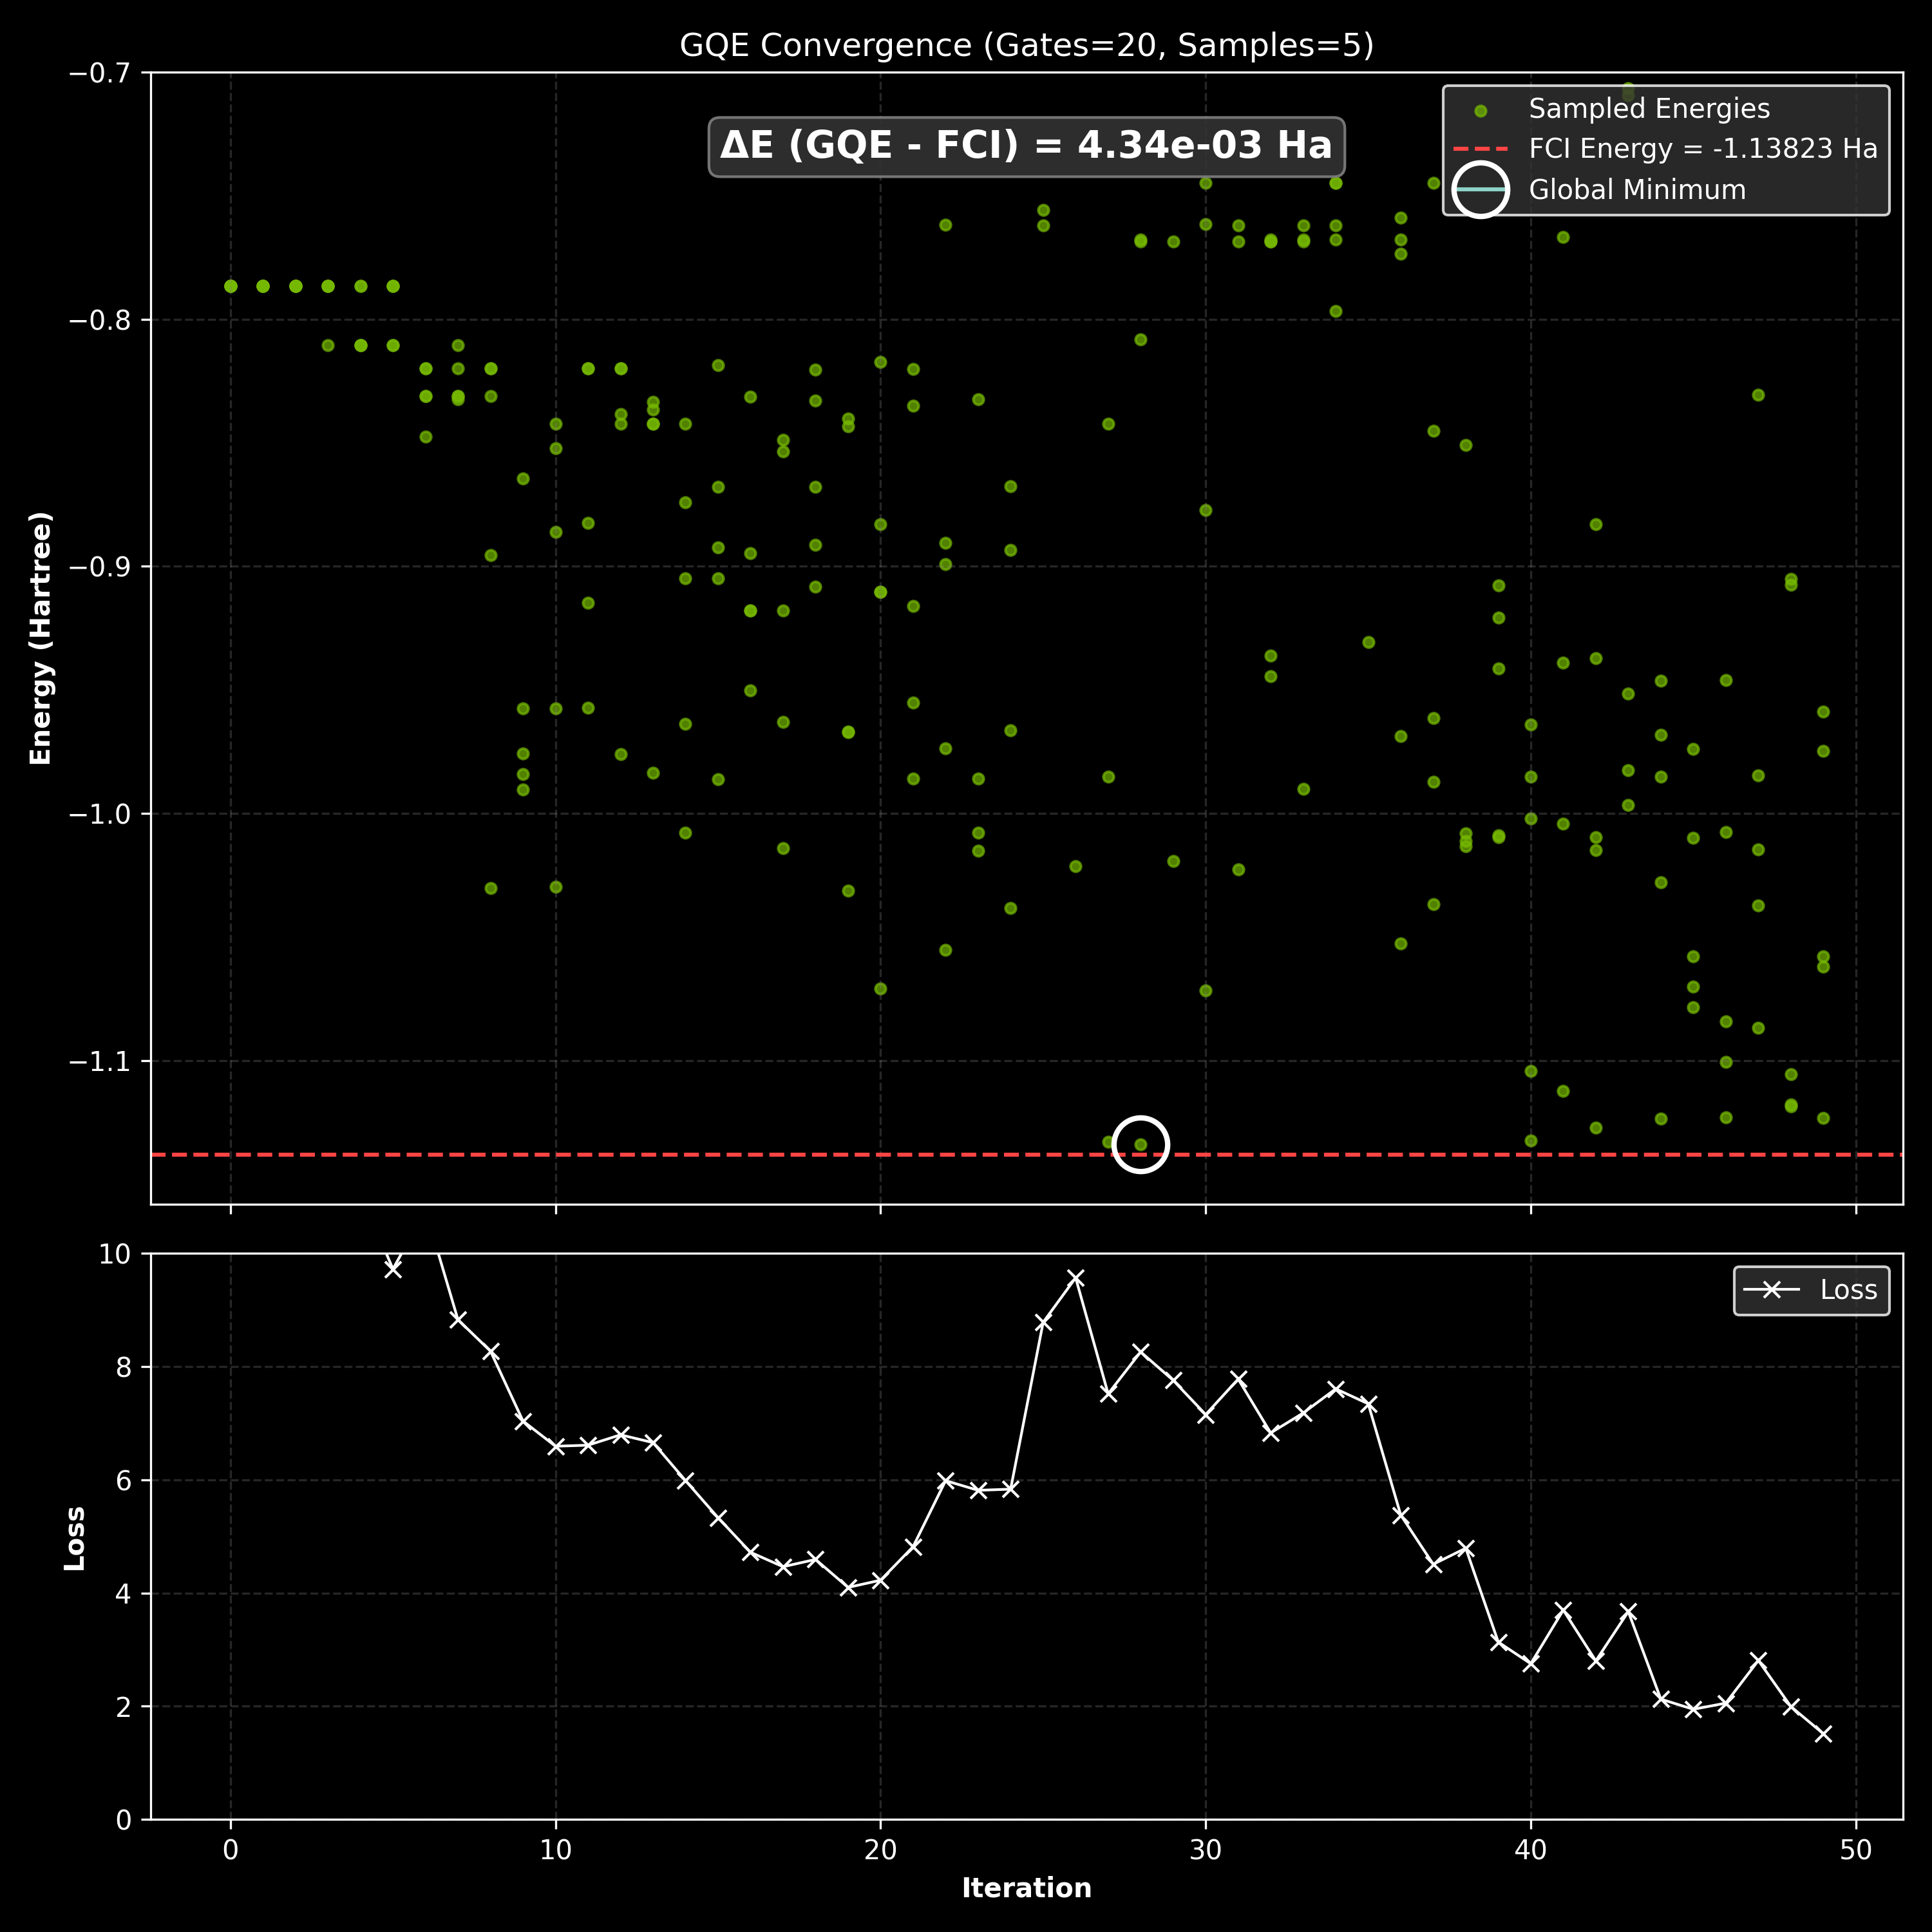

In [13]:
display(Image(filename='low_temp.png', width=600))
display(Image(filename='baseline.png', width=600))
display(Image(filename='high_temp.png', width=600))

The impact of temperature is slightly harder to connect to the result, but it can be observed in the plots.   Recall that the temperature tunes the probability that the model samples less likely operators when building the circuit.  Notice the spread of the samples. Clearly, they spread increases as the temperature is raised.  This is important for larger systems where the search space is enormous and there may be many local minima that yield poor solutions.  In the case of $H_2$ the system is simple so there is not as much impact from temperature on the result.

Underneath the hood, GQE uses an adaptive temperature schedule that balances this tradeoff to ensure the balance between quality results and exploration of the Hilbert space by slowly increasing the temperature in later epochs.

### Exploring Learning Rate

The learning rate is another key parameter that shows up in many AI applications and essentially controls how much the neural network parameters are adjusted each epoch.  Try running the default setting with a high and low learning rate.  What do you expect?


In [14]:
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 5 --lr 1e-9 --temperature 5 --output_file 'low_lr.png'
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 5 --lr 1e-4 --temperature 5 --output_file 'high_lr.png'


Full CI Energy (R-CASCI): -1.1382282118692277
Configuration: max_iters=50, ngates=20, num_samples=5, temperature=5.0
Seed set to 3047
total trainable params: 86.21M
epoch 0 loss tensor(1.8438, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.9508507251739502 tensor(-1.1069)
epoch 1 loss tensor(2.4547, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.36059069633483887 tensor(-1.1206)
epoch 2 loss tensor(2.1247, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.4432227611541748 tensor(-1.1040)
epoch 3 loss tensor(1.5438, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3696177005767822 tensor(-1.1187)
epoch 4 loss tensor(0.8484, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3669087886810303 tensor(-1.1058)
epoch 5 loss tensor(3.1917, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3594229221343994 tensor(-1.0407)
epoch 6 loss tensor(2.8288, device='cuda:0', gra

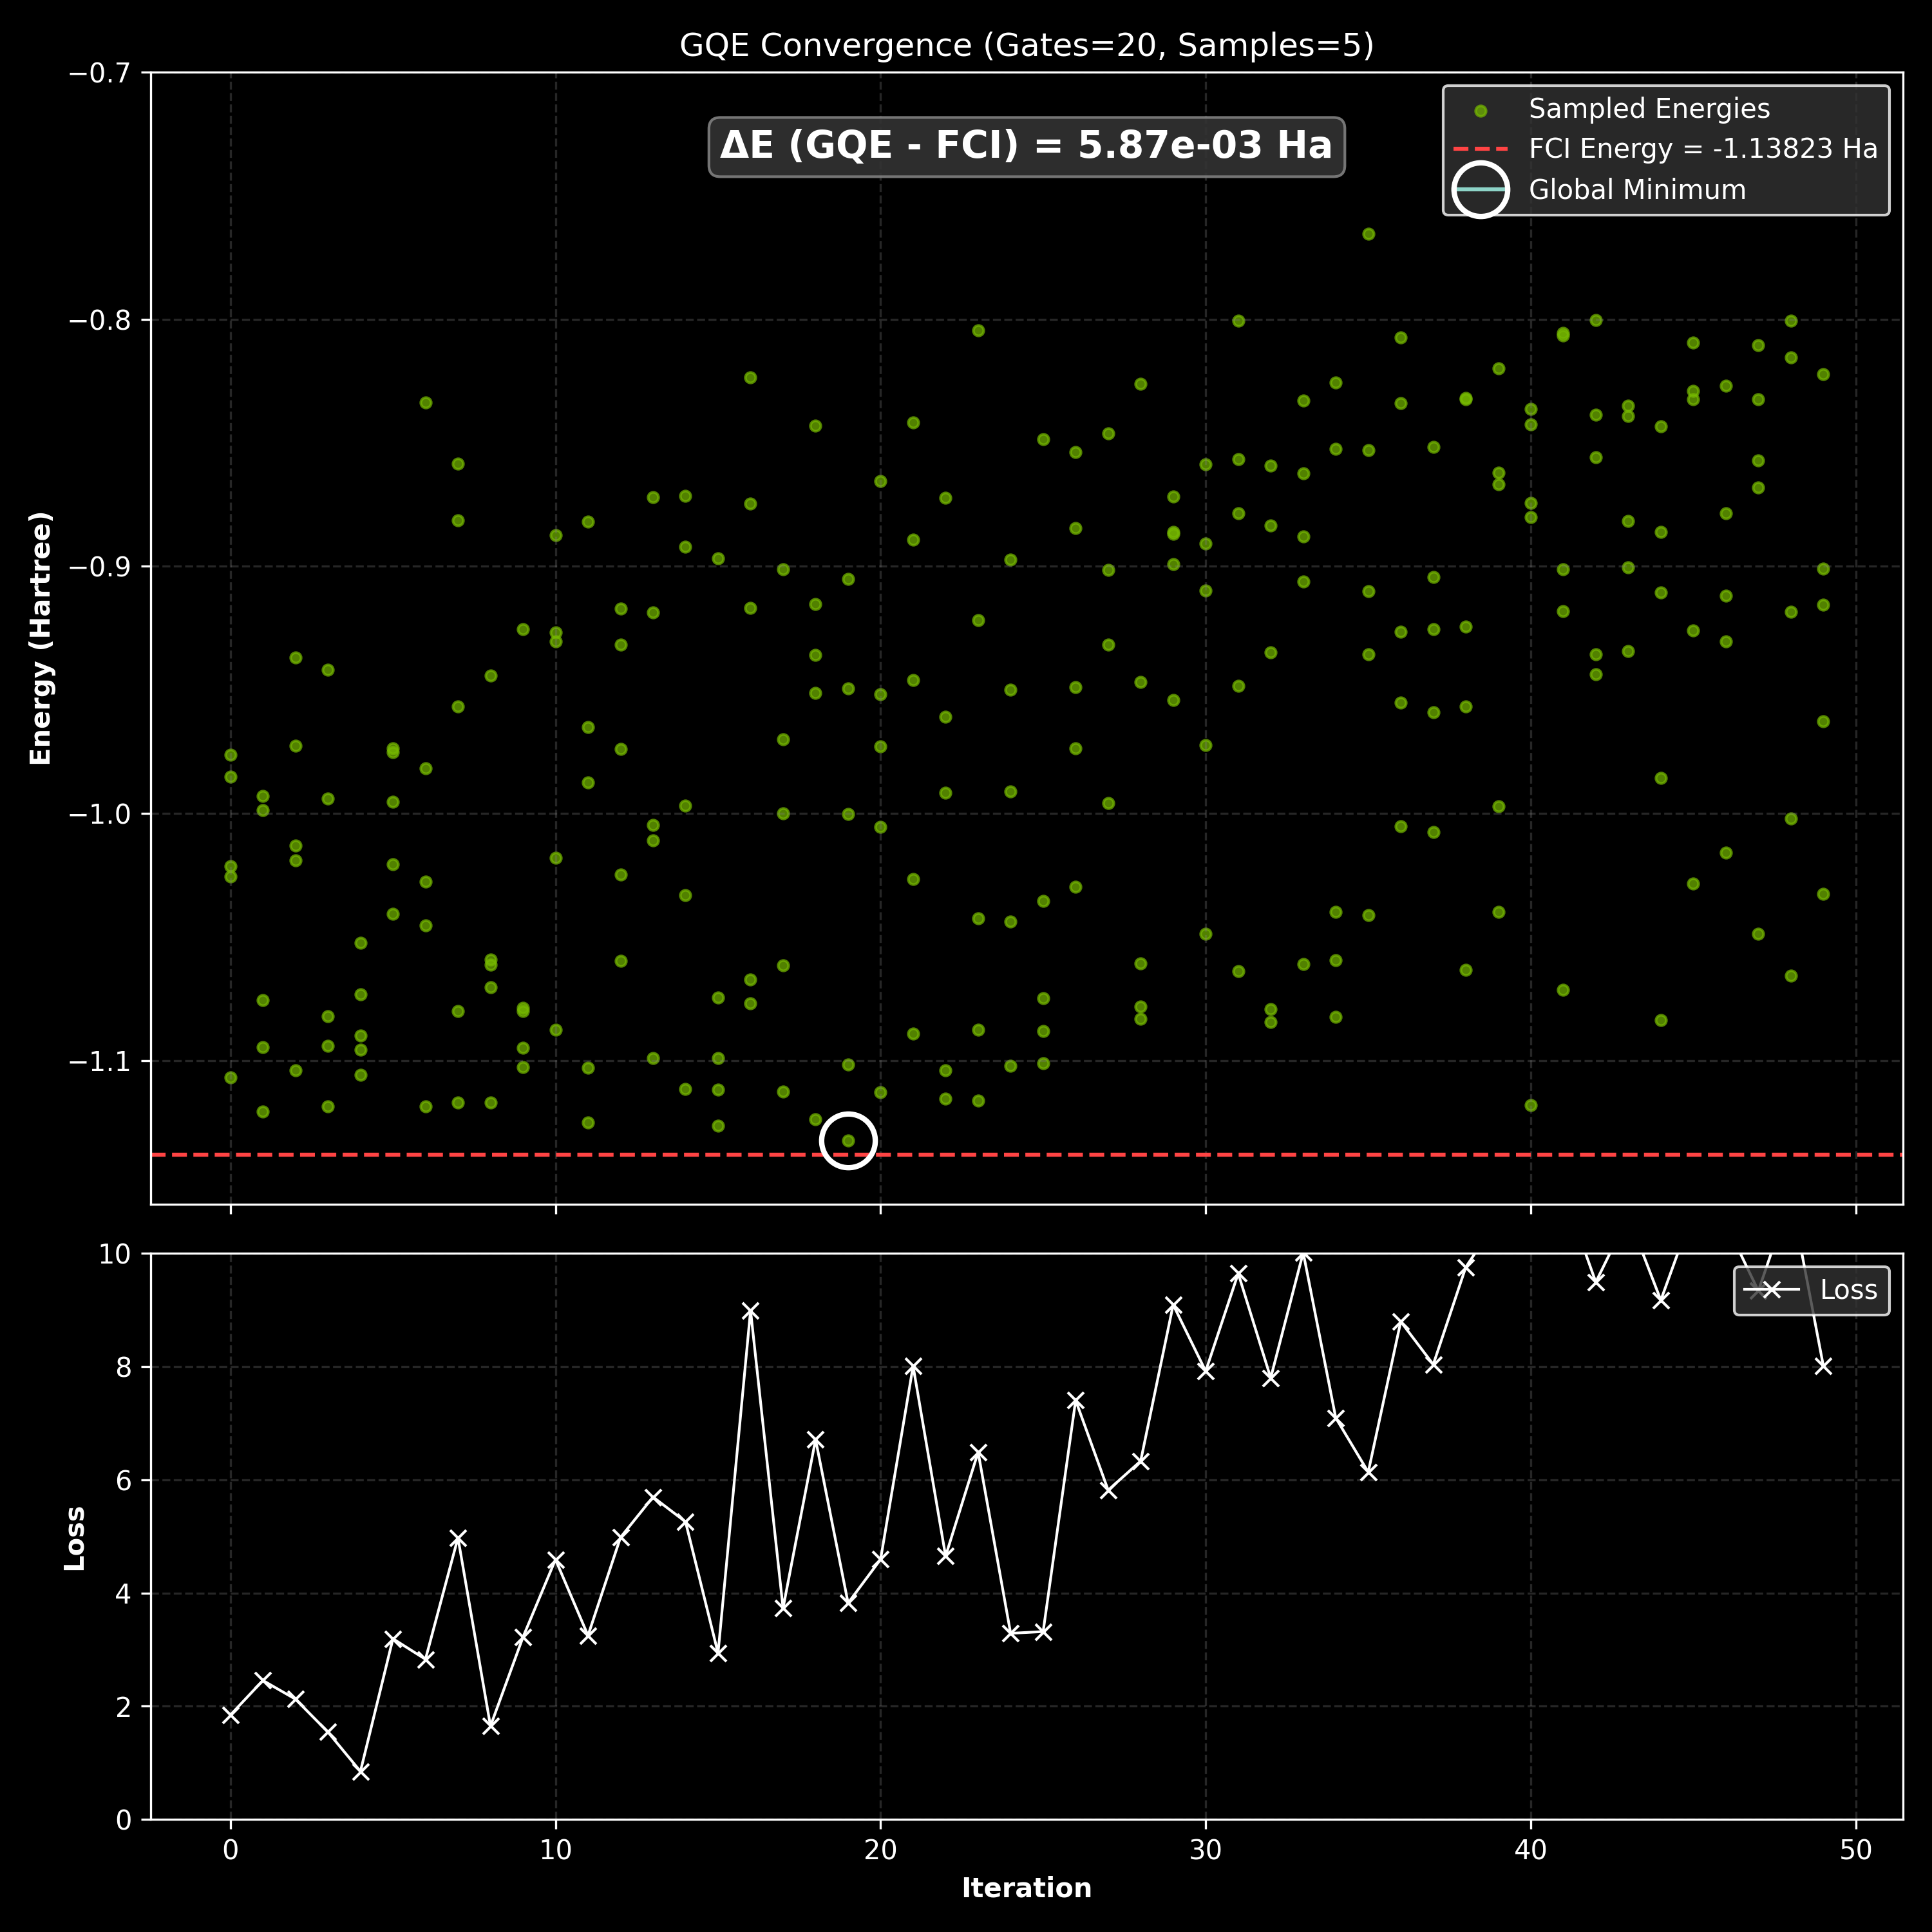

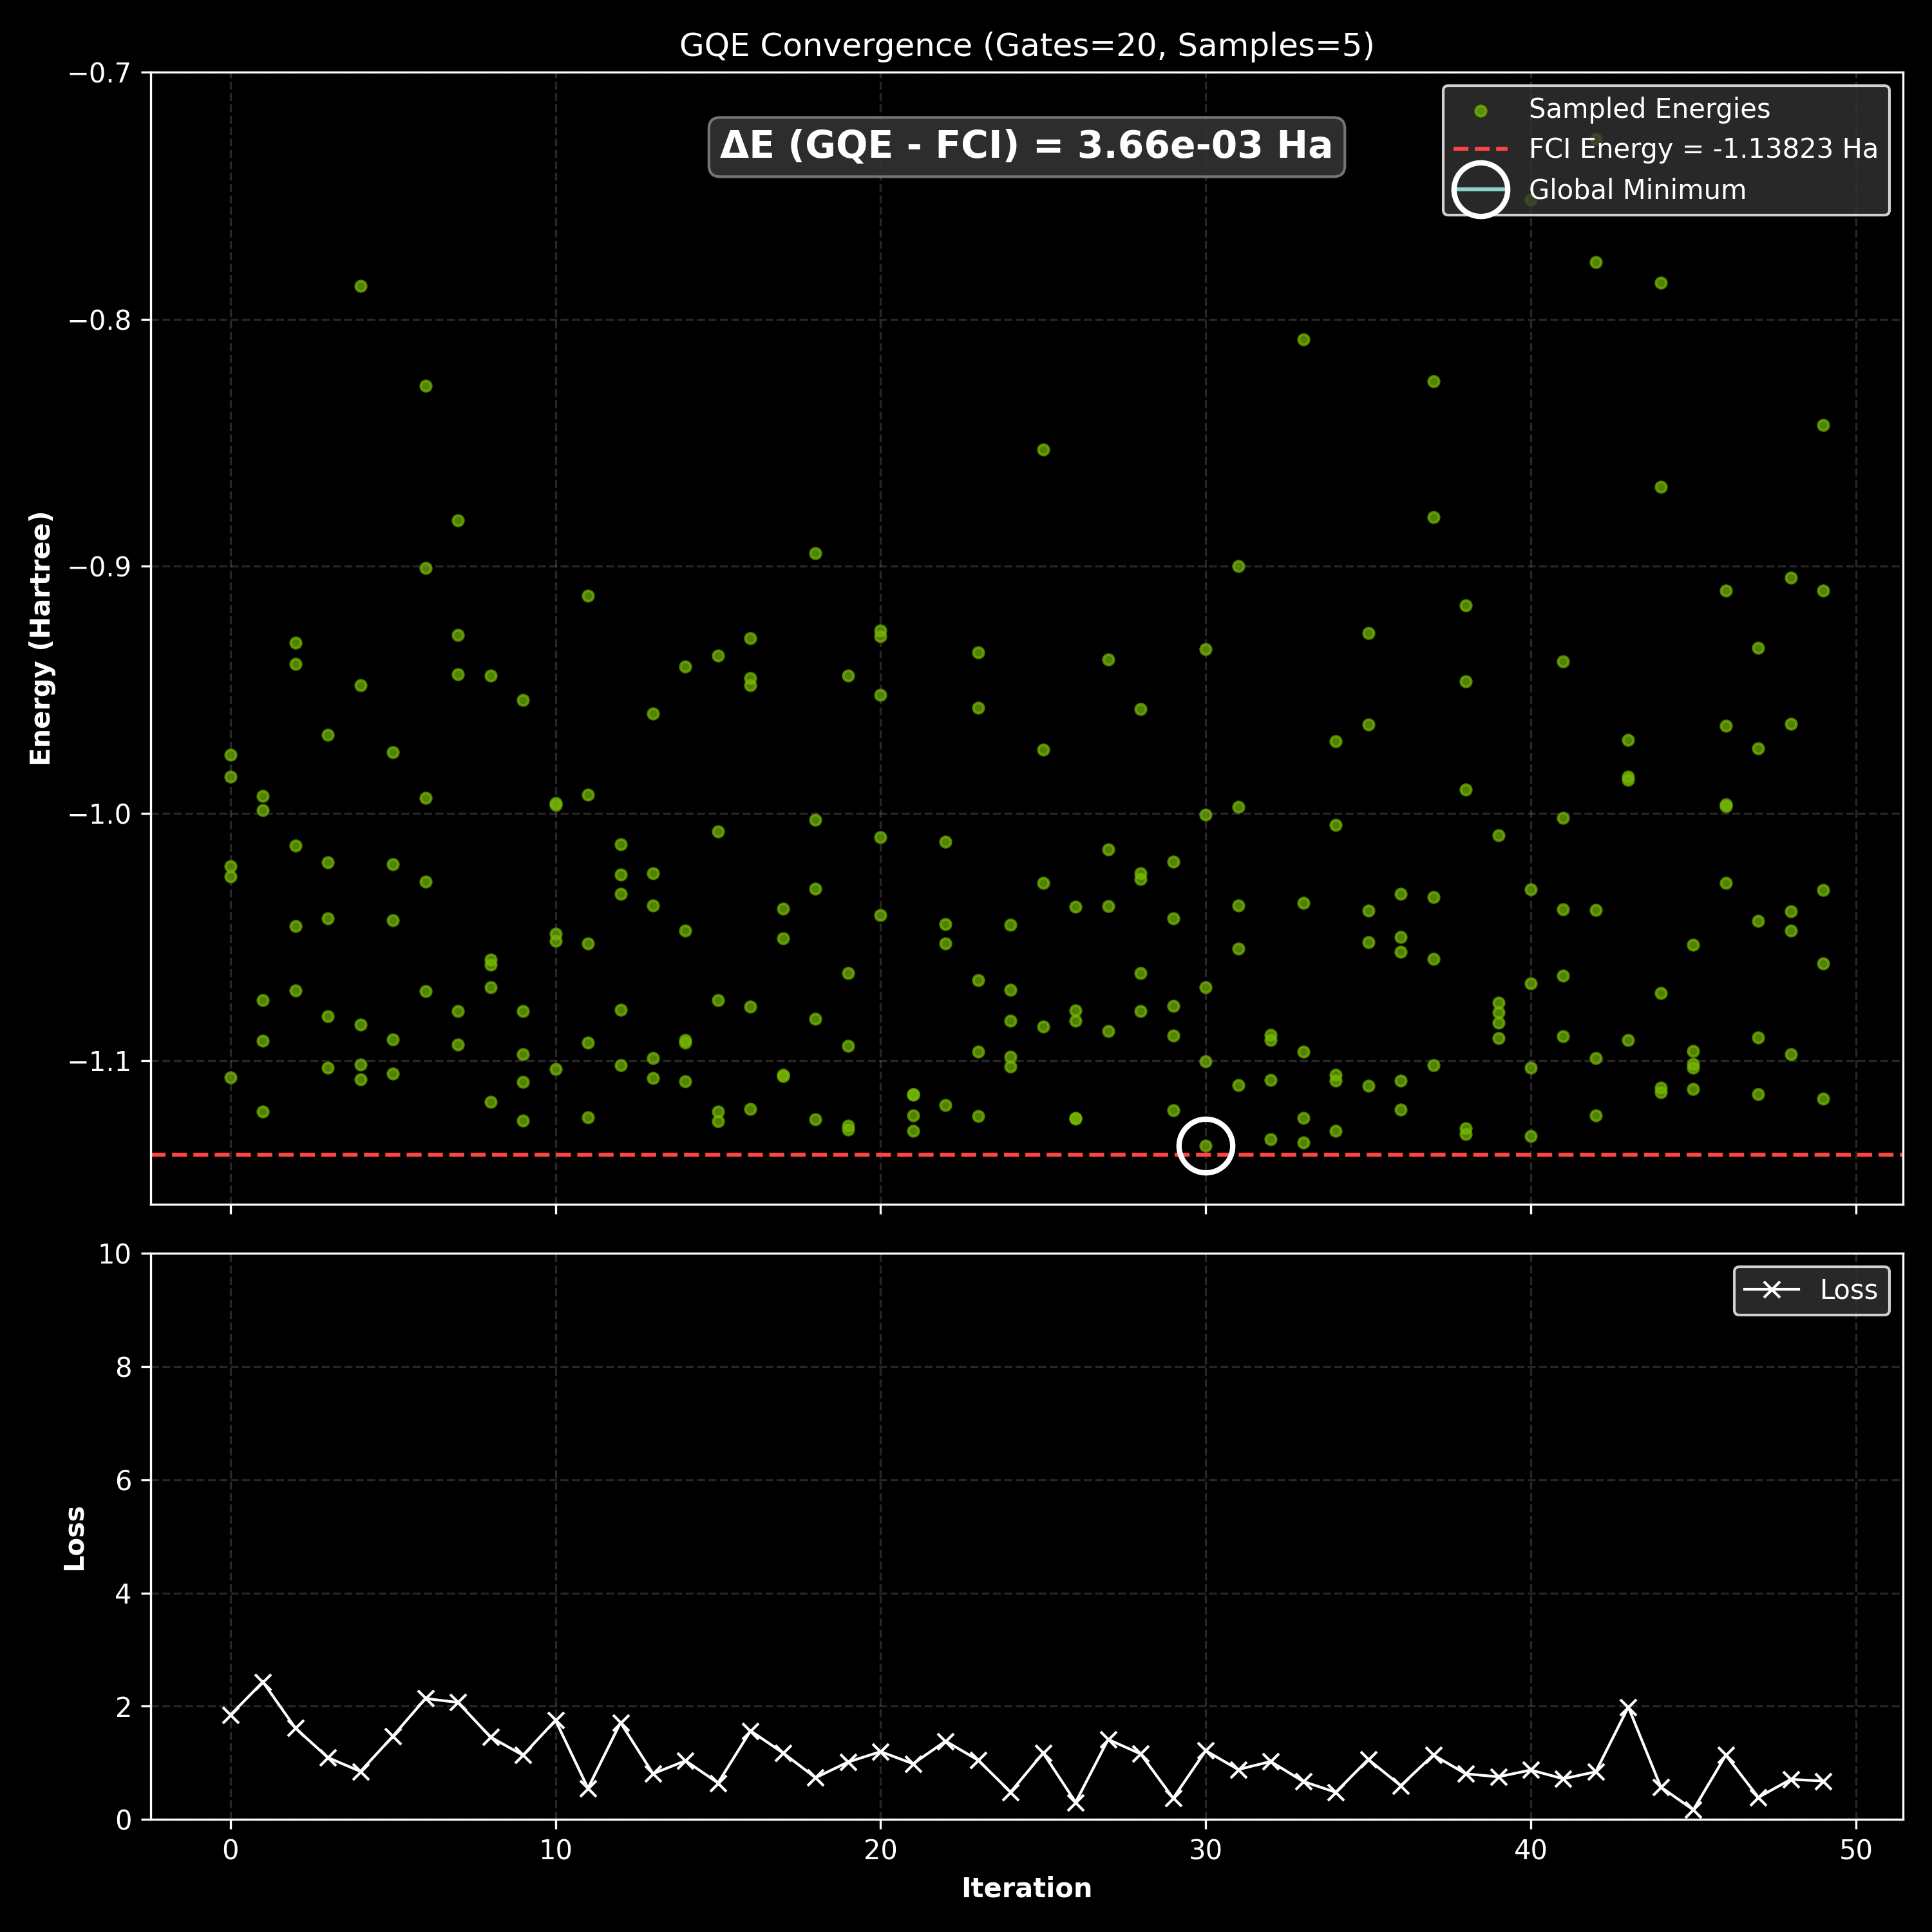

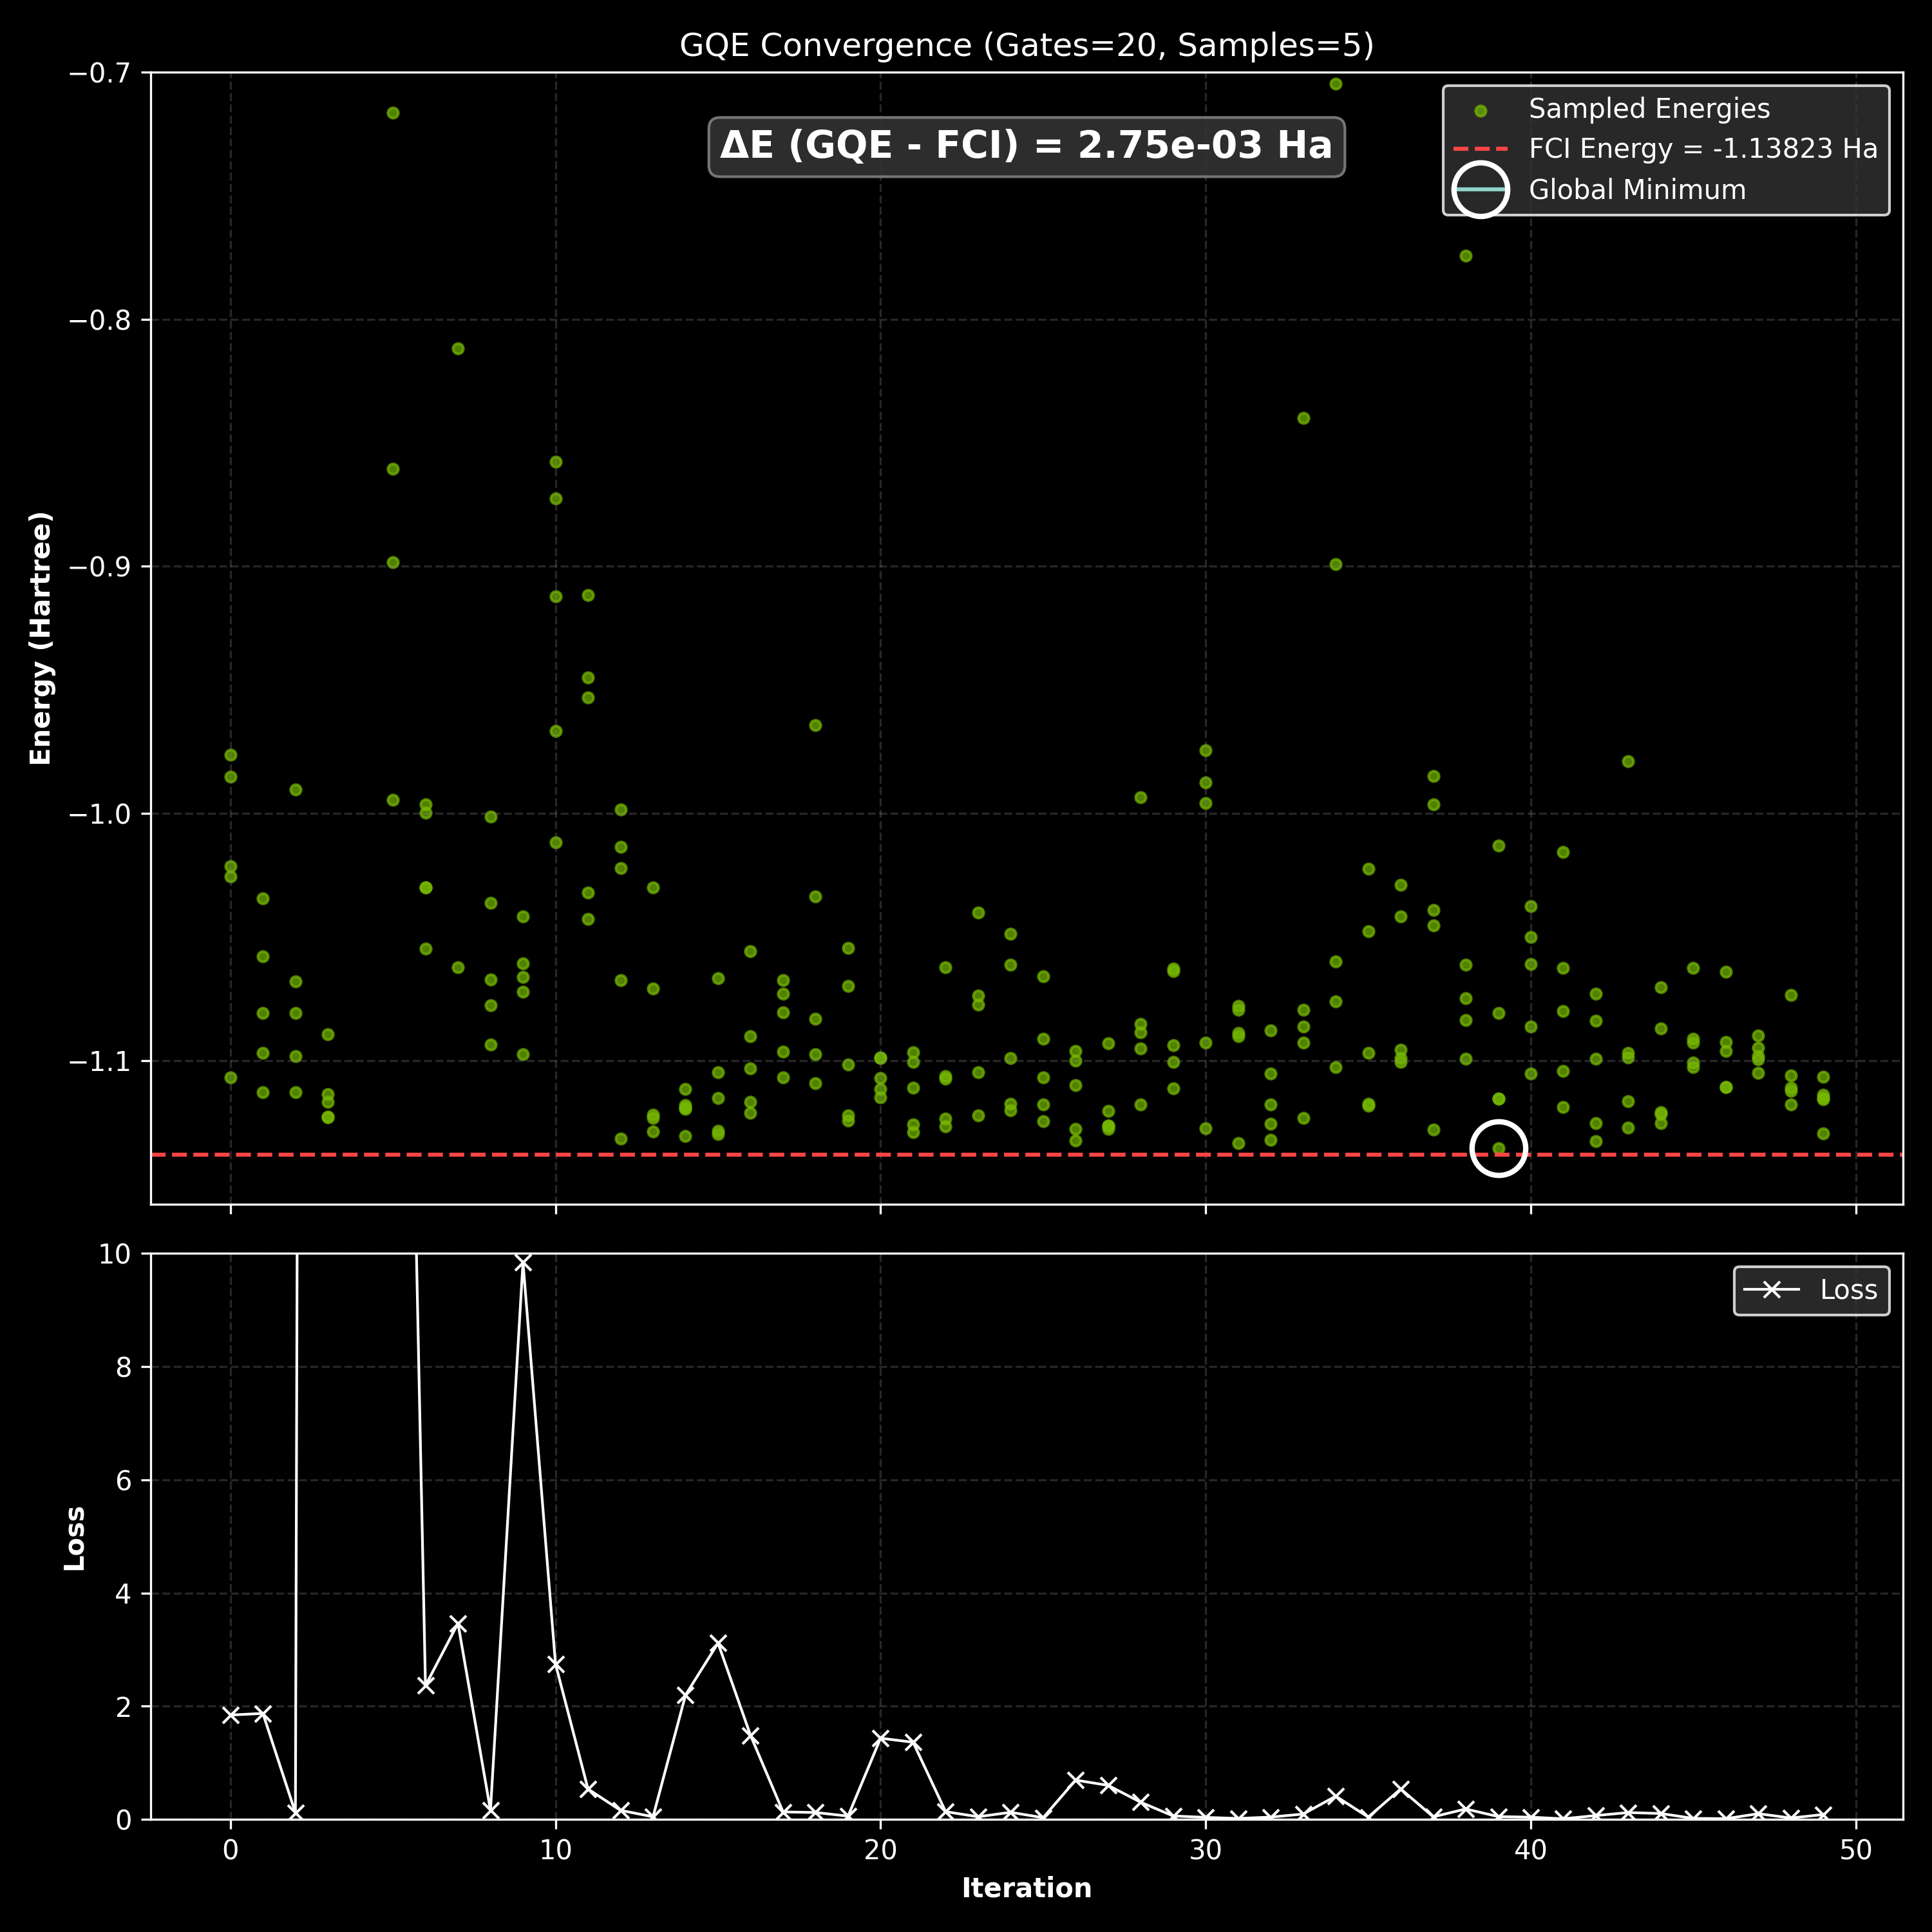

In [15]:
display(Image(filename='low_lr.png', width=600))
display(Image(filename='baseline.png', width=600))
display(Image(filename='high_lr.png', width=600))

Notice in the first plot, the learning rate is so small, the model does not really learn, and the cost goes up even! Essentially, the samples do not guide the training or will do so at such a slow rate it is impractical.  On the flip side, notice how a high learning rate sends massive shocks to the parameters resulting in some large spikes in the loss when higher energy circuits are sampled.  This can cause problems and even cause the model to overshoot the correct answer.  This is particularly a problem when the temperature is high, and the learning rate is high. Try running that case below.

In [16]:
!python3 ../aux_files/vqe_and_gqe/run_gqe_h2.py --max_iters 50 --ngates 20 --num_samples 5 --lr 1e-3 --temperature 30 --output_file 'high_lr_temp.png'

Full CI Energy (R-CASCI): -1.1382282118692268
Configuration: max_iters=50, ngates=20, num_samples=5, temperature=30.0
Seed set to 3047
total trainable params: 86.21M
epoch 0 loss tensor(16.8484, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 1.0135414600372314 tensor(-0.7865)
epoch 1 loss tensor(24.7304, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.35514211654663086 tensor(-1.1209)
epoch 2 loss tensor(12.0565, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3533203601837158 tensor(-1.1210)
epoch 3 loss tensor(4.0466, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.37022995948791504 tensor(-1.1124)
epoch 4 loss tensor(4.3480, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3584613800048828 tensor(-0.8798)
epoch 5 loss tensor(1.3084, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3535745143890381 tensor(-0.9208)
epoch 6 loss tensor(0.0811, device='cuda:0'

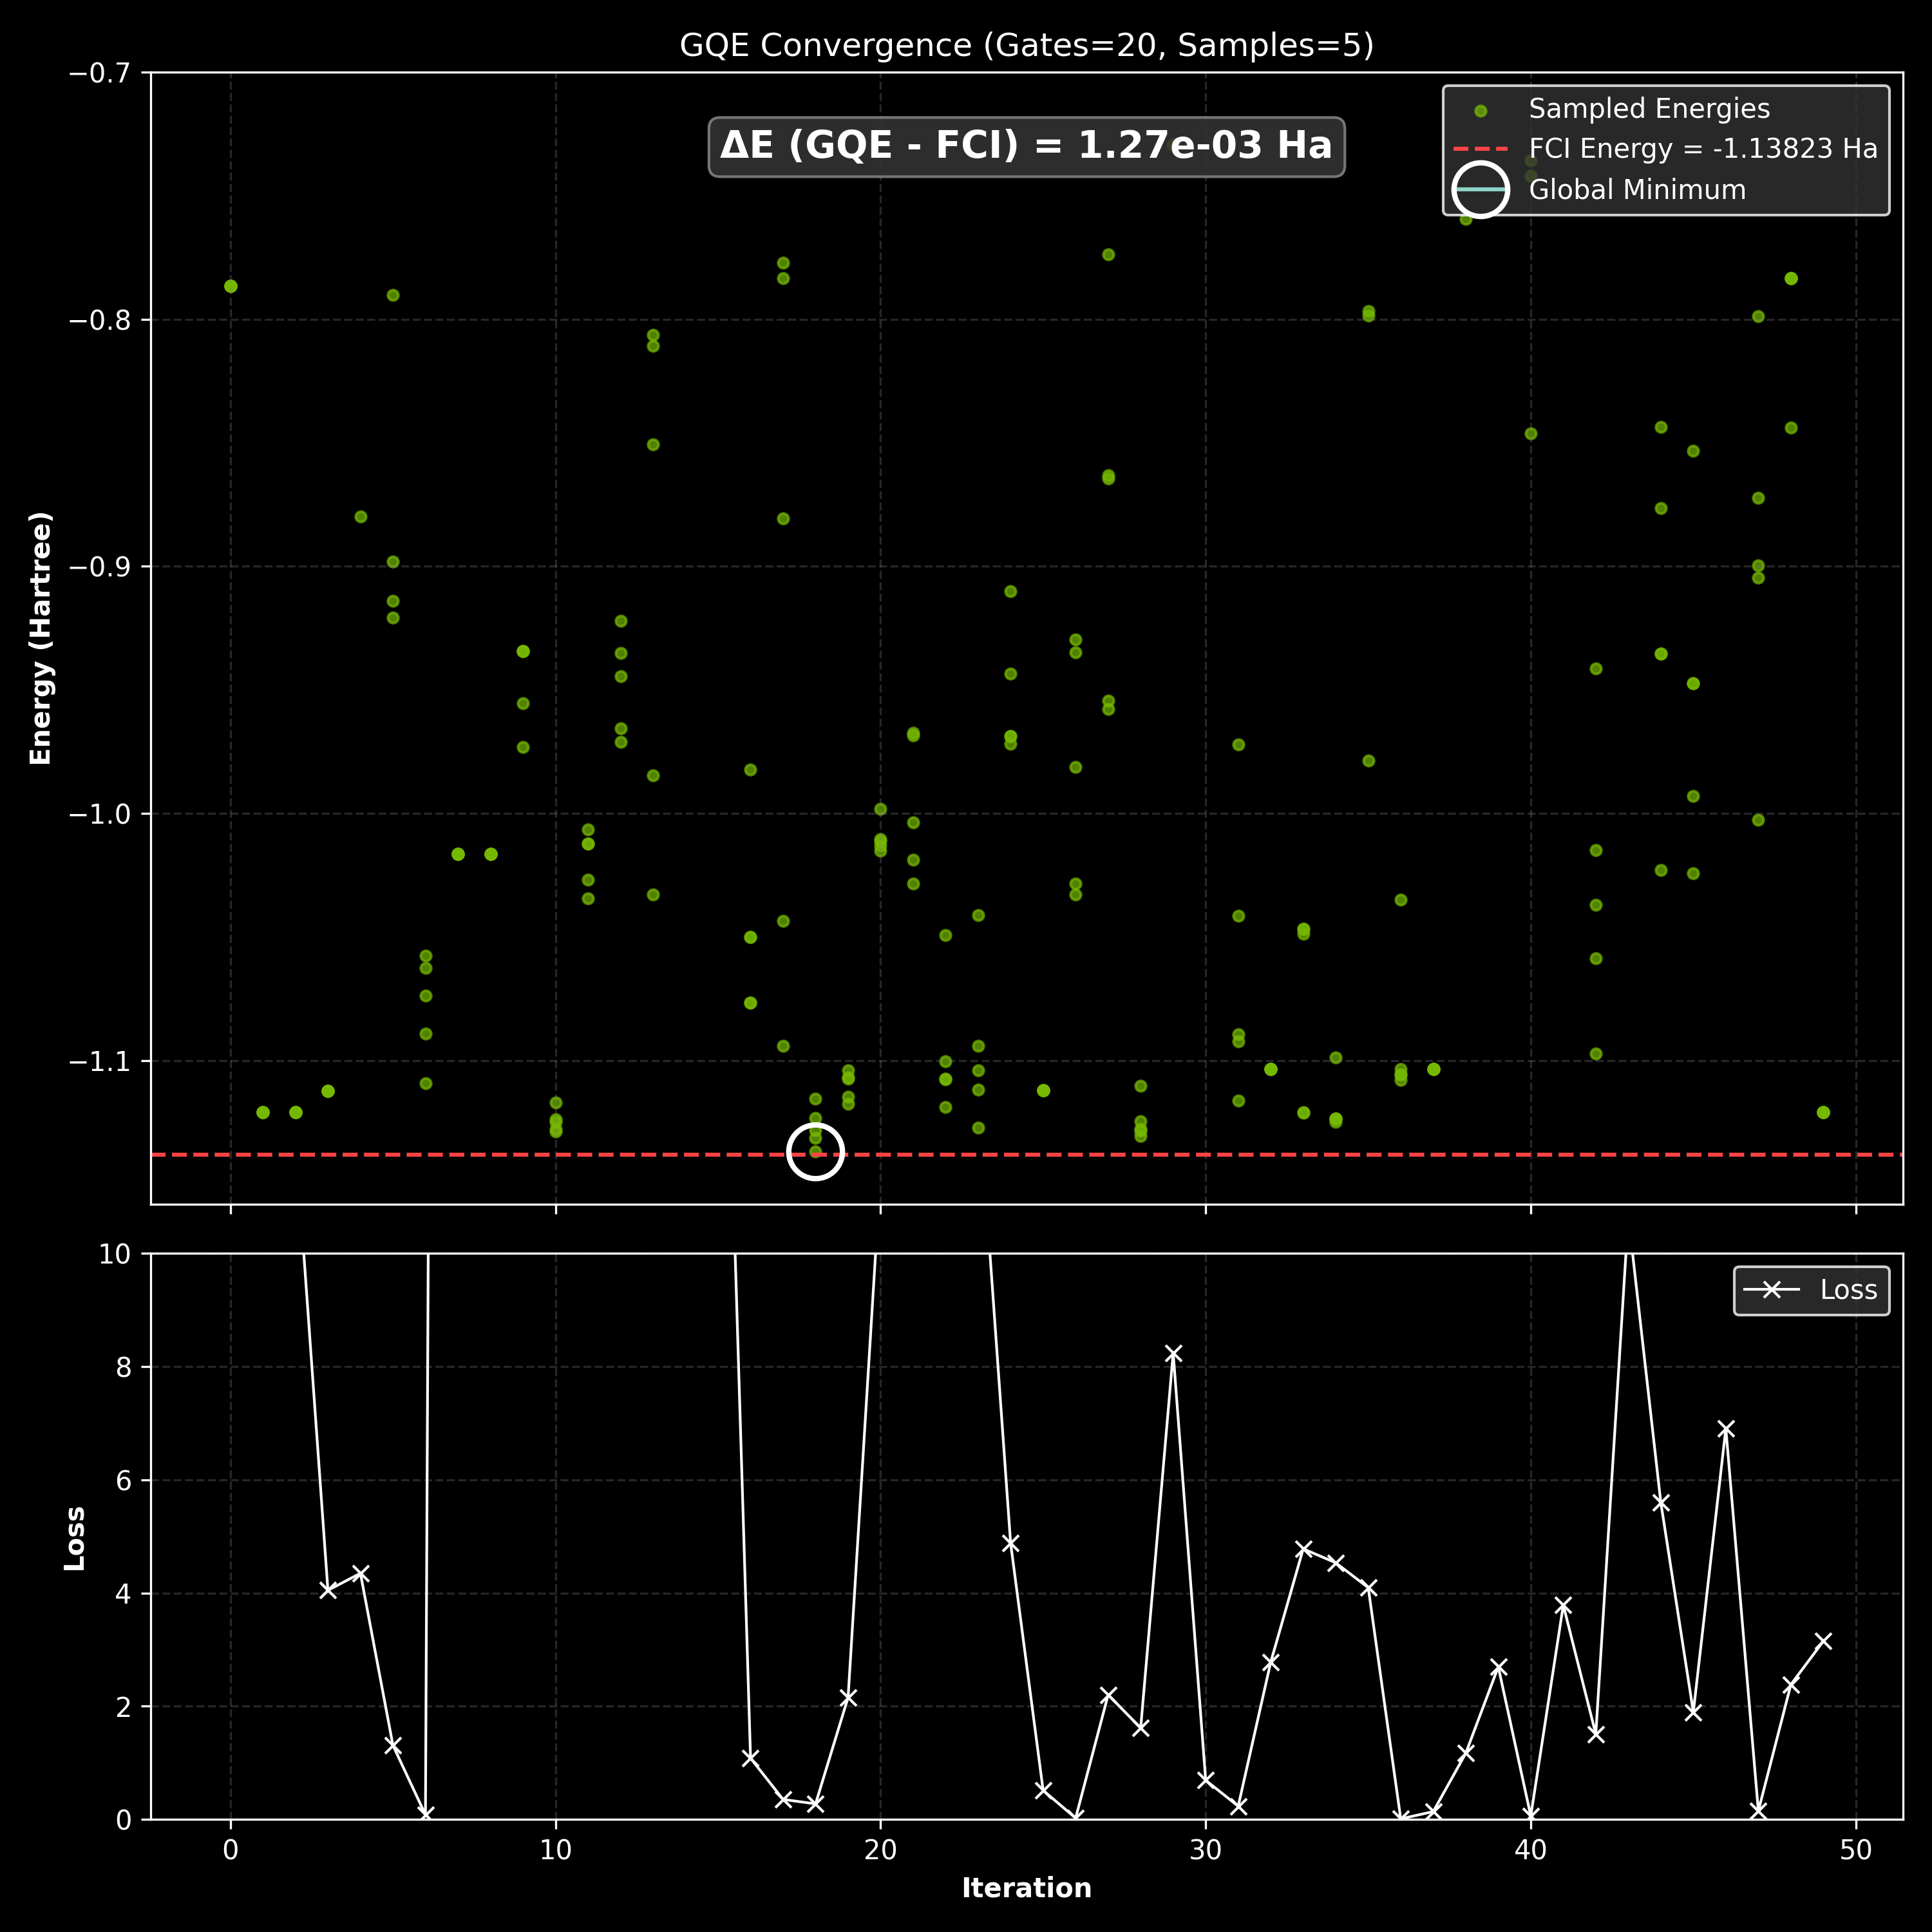

In [17]:
display(Image(filename='high_lr_temp.png', width=600))

In this case the training is a mess as the model is far too sensitive to higher energy samples.

Learning rate is another careful balance of time and training quality.

## Summary

The ground state problem is fundamental for chemistry and more broadly quantum computing.  In this notebook you learned how a prototypical variational method like VQE can help solve the problem but comes with a number of its own issues.  Much research is dedicated to solving this problem with clever techniques like AI.

The GQE method is an excellent and pioneering example of an improved approach that can converge with fewer quantum circuit executions, can run in parallel, and result in a pretrained model that can be transferred to other contexts.   Current work is exploring how GQE can be trained on chemical system A and then sample circuits for system B with little or no additional training.  

Likewise, GQE has already been applied to other domains like [combinatorial optimization](https://arxiv.org/abs/2501.16986) and shows great promise as a flexible and scalable quantum algorithm.  

To explore more features of GQE, check out the CUDA-Q Solvers [documentation](https://nvidia.github.io/cudaqx/examples_rst/solvers/gqe.html).
